In [ ]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install optuna
!pip install pytorch-lightning

In [ ]:
!pip install optuna-integration[pytorch_lightning]

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import defaultdict, Counter
import warnings
from typing import Dict, List, Tuple, Optional
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
warnings.filterwarnings('ignore')

In [ ]:


def load_and_clean_data(vrnet_csv_path: str, vrwalking_csv_path: str):
    """Load and clean CSV data with proper type handling"""

    print("Loading and cleaning data...")

    # Load VR.net data
    print(f"Loading VR.net data: {vrnet_csv_path}")
    vrnet_df = pd.read_csv(vrnet_csv_path)
    print(f"  Original shape: {vrnet_df.shape}")

    # Load VRWalking data
    print(f"Loading VRWalking data: {vrwalking_csv_path}")
    vrwalking_df = pd.read_csv(vrwalking_csv_path)
    print(f"  Original shape: {vrwalking_df.shape}")

    # Standardize FMS column names
    if 'fms_label' in vrnet_df.columns:
        vrnet_df['fms_score'] = pd.to_numeric(vrnet_df['fms_label'], errors='coerce')
        print("  ✓ VR.net: Using 'fms_label' column")
    elif 'fms' in vrnet_df.columns:
        vrnet_df['fms_score'] = pd.to_numeric(vrnet_df['fms'], errors='coerce')
        print("  ✓ VR.net: Using 'fms' column")
    else:
        print("  ⚠️  VR.net: No FMS column found")

    if 'fms' in vrwalking_df.columns:
        vrwalking_df['fms_score'] = pd.to_numeric(vrwalking_df['fms'], errors='coerce')
        print("  ✓ VRWalking: Using 'fms' column")
    elif 'fms_label' in vrwalking_df.columns:
        vrwalking_df['fms_score'] = pd.to_numeric(vrwalking_df['fms_label'], errors='coerce')
        print("  ✓ VRWalking: Using 'fms_label' column")
    else:
        print("  ⚠️  VRWalking: No FMS column found")

    # Add dataset identifiers
    vrnet_df['dataset'] = 'vrnet'
    vrwalking_df['dataset'] = 'vrwalking'

    # Clean and convert data types
    vrnet_df = clean_dataframe(vrnet_df, 'VR.net')
    vrwalking_df = clean_dataframe(vrwalking_df, 'VRWalking')

    return vrnet_df, vrwalking_df

def parse_tuple_string(value):
    """Parse tuple-like strings into numeric values"""
    if pd.isna(value) or value == '':
        return []

    if isinstance(value, str):
        # Handle different tuple formats
        value = value.strip()
        if value.startswith('(') and value.endswith(')'):
            # Remove parentheses
            value = value[1:-1]

        # Split by comma and convert to float
        try:
            parts = [float(x.strip()) for x in value.split(',')]
            return parts
        except:
            return []
    elif isinstance(value, (list, tuple)):
        try:
            return [float(x) for x in value]
        except:
            return []
    else:
        try:
            return [float(value)]
        except:
            return []

def clean_dataframe(df: pd.DataFrame, dataset_name: str) -> pd.DataFrame:
    """Clean dataframe with proper type conversion"""

    print(f"Cleaning {dataset_name} data...")

    # Identify metadata columns
    metadata_cols = {
        'participant_id', 'timestamp', 'fms', 'fms_label', 'fms_score',
        'segment_id', 'dataset', 'folder_name', 'frame'
    }

    # Clean each column
    for col in df.columns:
        if col in metadata_cols:
            # Handle metadata columns
            if col in ['timestamp', 'segment_id', 'frame']:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            elif col == 'participant_id':
                df[col] = df[col].astype(str)
            continue

        # Handle feature columns
        if col in df.columns:
            # Check if column contains tuple-like strings
            sample_values = df[col].dropna().head(10)

            has_tuples = False
            for val in sample_values:
                if isinstance(val, str) and ('(' in str(val) or ',' in str(val)):
                    has_tuples = True
                    break

            if has_tuples:
                # Parse tuple strings into separate columns
                print(f"  Parsing tuple column: {col}")
                parsed_values = df[col].apply(parse_tuple_string)

                # Find maximum tuple length
                max_len = max([len(val) for val in parsed_values if len(val) > 0], default=1)

                # Create separate columns for each tuple element
                for i in range(max_len):
                    new_col = f"{col}_{i}"
                    df[new_col] = [val[i] if i < len(val) else np.nan for val in parsed_values]
                    df[new_col] = pd.to_numeric(df[new_col], errors='coerce')

                # Drop original tuple column
                df = df.drop(columns=[col])
            else:
                # Convert to numeric
                df[col] = pd.to_numeric(df[col], errors='coerce')

    print(f"  Cleaned shape: {df.shape}")
    print(f"  FMS score range: {df['fms_score'].min():.2f} - {df['fms_score'].max():.2f}")

    return df

class EnhancedTimeSeriesProcessor:
    """Enhanced processor with outlier removal, data balancing, and contextual features"""

    def __init__(self, window_size: int = 60, overlap: float = 0.5):
        self.window_size = window_size
        self.overlap = overlap
        self.scaler = RobustScaler()
        self.outlier_detector = IsolationForest(contamination=0.1, random_state=42)

    def identify_contextual_features(self, df: pd.DataFrame) -> Dict[str, List[str]]:
        """Identify contextual features mentioned as highly correlated with FMS"""

        contextual_features = {
            'timing_features': [],
            'frame_features': [],
            'eye_features': [],
            'spatial_features': [],
            'movement_features': []
        }

        # Search for contextual features (case insensitive)
        for col in df.columns:
            col_lower = col.lower()
            if any(keyword in col_lower for keyword in ['eyeframe', 'eye_frame', 'eye']):
                contextual_features['eye_features'].append(col)
            elif any(keyword in col_lower for keyword in ['vivetiming', 'vive_timing', 'timing']):
                contextual_features['timing_features'].append(col)
            elif any(keyword in col_lower for keyword in ['frame', 'timestamp']):
                contextual_features['frame_features'].append(col)
            elif any(keyword in col_lower for keyword in ['position', 'pos', 'location', 'x', 'y', 'z']):
                contextual_features['spatial_features'].append(col)
            elif any(keyword in col_lower for keyword in ['velocity', 'vel', 'speed', 'acceleration', 'accel']):
                contextual_features['movement_features'].append(col)

        return contextual_features

    def remove_outliers(self, df: pd.DataFrame) -> pd.DataFrame:
        """Remove outliers using Isolation Forest and statistical methods"""

        print("Removing outliers...")
        original_len = len(df)

        # Remove extreme FMS outliers (outside reasonable range)
        df = df[(df['fms_score'] >= 1) & (df['fms_score'] <= 10)]

        # Get numeric feature columns
        metadata_cols = {
            'participant_id', 'timestamp', 'fms', 'fms_label', 'fms_score',
            'segment_id', 'dataset', 'folder_name', 'frame'
        }
        numeric_cols = [col for col in df.columns if col not in metadata_cols
                       and df[col].dtype in [np.float64, np.float32, np.int64, np.int32]]

        if numeric_cols:
            # Prepare data for outlier detection
            feature_data = df[numeric_cols].fillna(0).values

            # Use Isolation Forest for multivariate outlier detection
            outlier_labels = self.outlier_detector.fit_predict(feature_data)
            df = df[outlier_labels == 1]  # Keep inliers only

        # Remove statistical outliers using IQR method for FMS scores
        Q1 = df['fms_score'].quantile(0.25)
        Q3 = df['fms_score'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df['fms_score'] >= lower_bound) & (df['fms_score'] <= upper_bound)]

        print(f"  Removed {original_len - len(df)} outliers ({(original_len - len(df))/original_len*100:.1f}%)")
        print(f"  Remaining samples: {len(df)}")

        return df

    def create_contextual_features(self, window_data: pd.DataFrame,
                                 contextual_features: Dict[str, List[str]]) -> np.ndarray:
        """Create enhanced features including contextual information"""

        # Standard statistical features
        metadata_cols = {
            'participant_id', 'timestamp', 'fms', 'fms_label', 'fms_score',
            'segment_id', 'dataset', 'folder_name', 'frame'
        }

        feature_cols = [col for col in window_data.columns if col not in metadata_cols]
        numeric_cols = [col for col in feature_cols
                       if window_data[col].dtype in [np.float64, np.float32, np.int64, np.int32]]

        if not numeric_cols:
            return np.array([0.0] * 50)

        numeric_data = window_data[numeric_cols].fillna(0).values
        numeric_data = np.nan_to_num(numeric_data, nan=0.0, posinf=0.0, neginf=0.0)

        features = []

        # Basic statistical features
        if len(numeric_data) > 0:
            features.extend([
                np.mean(numeric_data),
                np.std(numeric_data),
                np.min(numeric_data),
                np.max(numeric_data),
                np.median(numeric_data),
                np.percentile(numeric_data, 25),
                np.percentile(numeric_data, 75),
                stats.skew(numeric_data.flatten()),
                stats.kurtosis(numeric_data.flatten()),
                np.ptp(numeric_data)  # Range
            ])
        else:
            features.extend([0.0] * 10)

        # Temporal features
        if len(numeric_data) > 1:
            # Linear trend
            time_points = np.arange(len(numeric_data))
            slopes = []
            for col_idx in range(numeric_data.shape[1]):
                try:
                    slope = np.polyfit(time_points, numeric_data[:, col_idx], 1)[0]
                    slopes.append(slope)
                except:
                    slopes.append(0.0)

            features.extend([
                np.mean(slopes),
                np.std(slopes),
                np.max(slopes),
                np.min(slopes)
            ])

            # Velocity and acceleration
            velocity = np.diff(numeric_data, axis=0)
            if len(velocity) > 0:
                features.extend([
                    np.mean(velocity),
                    np.std(velocity),
                    np.mean(np.abs(velocity))
                ])
            else:
                features.extend([0.0] * 3)

            # Acceleration
            if len(velocity) > 1:
                acceleration = np.diff(velocity, axis=0)
                features.extend([
                    np.mean(acceleration),
                    np.std(acceleration)
                ])
            else:
                features.extend([0.0] * 2)
        else:
            features.extend([0.0] * 9)

        # Contextual features (enhanced for highly correlated features)
        contextual_feature_values = []

        # Process contextual features with special attention
        for feature_type, feature_list in contextual_features.items():
            available_features = [f for f in feature_list if f in window_data.columns]

            if available_features:
                contextual_data = window_data[available_features].fillna(0).values
                if len(contextual_data) > 0:
                    # Enhanced statistics for contextual features
                    contextual_feature_values.extend([
                        np.mean(contextual_data),
                        np.std(contextual_data),
                        np.max(contextual_data) - np.min(contextual_data),  # Range
                        np.mean(np.diff(contextual_data, axis=0)) if len(contextual_data) > 1 else 0.0,  # Trend
                    ])
                else:
                    contextual_feature_values.extend([0.0] * 4)
            else:
                contextual_feature_values.extend([0.0] * 4)

        features.extend(contextual_feature_values)

        # Frequency domain features (if window is large enough)
        if len(numeric_data) > 8:
            # Simple frequency features using FFT
            try:
                fft_features = []
                for col_idx in range(min(3, numeric_data.shape[1])):  # Limit to first 3 columns
                    fft = np.fft.fft(numeric_data[:, col_idx])
                    fft_magnitude = np.abs(fft)
                    fft_features.extend([
                        np.mean(fft_magnitude[:len(fft_magnitude)//2]),  # Mean of positive frequencies
                        np.argmax(fft_magnitude[:len(fft_magnitude)//2])  # Dominant frequency
                    ])

                features.extend(fft_features)
            except:
                features.extend([0.0] * 6)
        else:
            features.extend([0.0] * 6)

        return np.array(features, dtype=np.float32)

    def create_balanced_sequences(self, sequences: List[Dict]) -> List[Dict]:
        """Create balanced dataset using oversampling for minority classes"""

        print("Balancing dataset...")

        # Convert continuous FMS scores to ordinal classes for balancing
        fms_scores = [seq['target_fms'] for seq in sequences]
        fms_classes = [int(np.round(score)) - 1 for score in fms_scores]  # 0-9 classes

        # Count class distribution
        class_counts = Counter(fms_classes)
        print(f"  Original distribution: {dict(sorted(class_counts.items()))}")

        # Find target count (median or mean of class counts)
        target_count = int(np.median(list(class_counts.values())))

        # Group sequences by class
        class_sequences = defaultdict(list)
        for seq, cls in zip(sequences, fms_classes):
            class_sequences[cls].append(seq)

        # Balance by oversampling minority classes
        balanced_sequences = []

        for cls in range(10):  # FMS classes 1-10 (0-9 indexed)
            if cls in class_sequences:
                cls_sequences = class_sequences[cls]
                current_count = len(cls_sequences)

                # Add original sequences
                balanced_sequences.extend(cls_sequences)

                # Oversample if needed
                if current_count < target_count:
                    oversample_count = target_count - current_count
                    oversampled = np.random.choice(cls_sequences, size=oversample_count, replace=True)
                    balanced_sequences.extend(oversampled)

        # Shuffle the balanced dataset
        np.random.shuffle(balanced_sequences)

        # Show new distribution
        new_fms_classes = [int(np.round(seq['target_fms'])) - 1 for seq in balanced_sequences]
        new_class_counts = Counter(new_fms_classes)
        print(f"  Balanced distribution: {dict(sorted(new_class_counts.items()))}")
        print(f"  Total sequences: {len(sequences)} -> {len(balanced_sequences)}")

        return balanced_sequences

    def process_all_data(self, vrnet_df: pd.DataFrame, vrwalking_df: pd.DataFrame) -> Tuple:
        """Process all data with enhancements"""

        print("Processing data with enhancements...")

        # Remove outliers from each dataset
        vrnet_df = self.remove_outliers(vrnet_df)
        vrwalking_df = self.remove_outliers(vrwalking_df)

        # Combine datasets
        combined_df = pd.concat([vrnet_df, vrwalking_df], ignore_index=True)
        combined_df = combined_df.dropna(subset=['fms_score'])

        # Identify contextual features
        contextual_features = self.identify_contextual_features(combined_df)
        print(f"  Identified contextual features: {contextual_features}")

        all_sequences = []

        # Process each participant
        for participant_id in combined_df['participant_id'].unique():
            participant_df = combined_df[combined_df['participant_id'] == participant_id]

            if len(participant_df) < self.window_size:
                continue

            participant_df = participant_df.sort_values('timestamp').reset_index(drop=True)

            # Create sequences with overlap
            step_size = max(1, int(self.window_size * (1 - self.overlap)))

            for i in range(0, len(participant_df) - self.window_size + 1, step_size):
                window_data = participant_df.iloc[i:i + self.window_size]
                target_fms = window_data['fms_score'].iloc[-1]

                if pd.isna(target_fms):
                    continue

                # Create enhanced features
                features = self.create_contextual_features(window_data, contextual_features)

                all_sequences.append({
                    'features': features,
                    'target_fms': float(target_fms),
                    'participant_id': participant_id,
                    'dataset': participant_df['dataset'].iloc[0]
                })

        print(f"Created {len(all_sequences)} sequences")

        # Balance the dataset
        balanced_sequences = self.create_balanced_sequences(all_sequences)

        # Extract arrays
        X = np.array([seq['features'] for seq in balanced_sequences])
        y = np.array([seq['target_fms'] for seq in balanced_sequences])
        participant_ids = [seq['participant_id'] for seq in balanced_sequences]
        datasets = [seq['dataset'] for seq in balanced_sequences]

        # Scale features
        print(f"Scaling {X.shape[1]} features...")
        X_scaled = self.scaler.fit_transform(X)

        print(f"Final balanced dataset: {X_scaled.shape[0]} sequences, {X_scaled.shape[1]} features")
        print(f"FMS range: {y.min():.2f} - {y.max():.2f}")

        return X_scaled, y, participant_ids, datasets

class EnhancedOrdinalModel(nn.Module):
    """Enhanced ordinal regression model with improved architecture"""

    def __init__(self, input_dim: int, hidden_dims: List[int] = [512, 256, 128, 64],
                 dropout: float = 0.3, num_ordinal_classes: int = 10):
        super().__init__()

        self.num_ordinal_classes = num_ordinal_classes

        # Enhanced feature extraction with residual connections
        self.input_norm = nn.BatchNorm1d(input_dim)

        # Feature extraction layers with residual connections
        layers = []
        prev_dim = input_dim

        for i, hidden_dim in enumerate(hidden_dims):
            # Main path
            layers.append(nn.Sequential(
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout)
            ))

            # Add skip connections for larger layers
            if prev_dim == hidden_dim:
                layers.append(nn.Identity())  # Skip connection

            prev_dim = hidden_dim

        self.feature_layers = nn.ModuleList(layers)

        # Attention mechanism for temporal features
        self.attention = nn.MultiheadAttention(
            embed_dim=prev_dim,
            num_heads=4,
            dropout=dropout,
            batch_first=True
        )

        # Ordinal regression components
        self.ordinal_projection = nn.Linear(prev_dim, 1)
        self.ordinal_thresholds = nn.Parameter(torch.linspace(-3, 3, num_ordinal_classes - 1))

        # Direct regression head
        self.regression_head = nn.Sequential(
            nn.Linear(prev_dim, prev_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(prev_dim // 2, 1)
        )

        self._init_weights()

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # Input normalization
        x = self.input_norm(x)

        # Feature extraction with residual connections
        features = x
        for layer in self.feature_layers:
            if isinstance(layer, nn.Identity):
                continue
            new_features = layer(features)

            # Add residual connection if dimensions match
            if features.shape[-1] == new_features.shape[-1]:
                features = features + new_features
            else:
                features = new_features

        # Self-attention for capturing complex relationships
        # Reshape for attention (batch_size, seq_len=1, features)
        attn_input = features.unsqueeze(1)
        attn_output, _ = self.attention(attn_input, attn_input, attn_input)
        features = attn_output.squeeze(1) + features  # Residual connection

        # Ordinal regression component
        ordinal_scores = self.ordinal_projection(features).squeeze(-1)
        sorted_thresholds = torch.sort(self.ordinal_thresholds)[0]

        # Compute cumulative probabilities
        cumulative_probs = torch.sigmoid(
            sorted_thresholds.unsqueeze(0) - ordinal_scores.unsqueeze(1)
        )

        # Convert to class probabilities
        padded_probs = torch.cat([
            torch.zeros(cumulative_probs.size(0), 1, device=cumulative_probs.device),
            cumulative_probs,
            torch.ones(cumulative_probs.size(0), 1, device=cumulative_probs.device)
        ], dim=1)

        class_probs = padded_probs[:, 1:] - padded_probs[:, :-1]

        # Expected value (continuous prediction)
        class_values = torch.arange(self.num_ordinal_classes, dtype=torch.float32, device=x.device) + 1
        expected_values = torch.sum(class_probs * class_values, dim=1)

        # Direct regression output
        regression_output = self.regression_head(features).squeeze(-1)

        return expected_values, regression_output, class_probs

    def predict_continuous(self, x: torch.Tensor) -> torch.Tensor:
        """Predict continuous FMS scores"""
        expected_values, regression_output, _ = self.forward(x)

        # Weighted combination
        combined_output = 0.6 * expected_values + 0.4 * regression_output

        # Clamp to valid FMS range
        return torch.clamp(combined_output, min=1.0, max=10.0)

# Fix the SimplifiedOrdinalLoss class:
class SimplifiedOrdinalLoss(nn.Module):
    """Simplified ordinal loss as backup"""

    def __init__(self, ordinal_weight: float = 0.7, regression_weight: float = 0.3):
        super().__init__()
        self.ordinal_weight = ordinal_weight
        self.regression_weight = regression_weight

    def ordinal_loss(self, class_probs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """Simple ordinal loss using cross entropy"""
        batch_size = class_probs.size(0)
        num_classes = class_probs.size(1)

        # Ensure targets are in valid range [1, 10] then convert to [0, 9]
        targets_clamped = torch.clamp(targets, min=1.0, max=10.0)
        target_classes = torch.clamp(torch.round(targets_clamped) - 1, 0, num_classes - 1).long()

        # Ensure class_probs are valid probabilities
        class_probs_safe = torch.clamp(class_probs, min=1e-7, max=1.0)
        class_probs_safe = class_probs_safe / class_probs_safe.sum(dim=1, keepdim=True)

        # Cross entropy loss
        return F.cross_entropy(torch.log(class_probs_safe + 1e-7), target_classes)

    def forward(self, expected_values: torch.Tensor, regression_output: torch.Tensor,
                class_probs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:

        # Clamp all inputs to safe ranges
        expected_values = torch.clamp(expected_values, min=1.0, max=10.0)
        regression_output = torch.clamp(regression_output, min=1.0, max=10.0)
        targets = torch.clamp(targets, min=1.0, max=10.0)

        # Ordinal loss
        ord_loss = self.ordinal_loss(class_probs, targets)

        # Regression loss
        reg_loss = F.smooth_l1_loss(regression_output, targets)

        # Combined prediction loss
        combined_pred = 0.7 * expected_values + 0.3 * regression_output
        combined_pred = torch.clamp(combined_pred, min=1.0, max=10.0)
        combined_loss = F.smooth_l1_loss(combined_pred, targets)

        # Total loss
        total_loss = (self.ordinal_weight * ord_loss +
                     self.regression_weight * reg_loss +
                     0.2 * combined_loss)

        return gtotal_loss

def compute_enhanced_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    """Compute only the requested metrics"""

    # Basic metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    # Accuracy metrics
    errors = np.abs(y_true - y_pred)
    acc_0_5 = np.mean(errors <= 0.5)
    acc_1_0 = np.mean(errors <= 1.0)
    acc_1_5 = np.mean(errors <= 1.5)

    return {
        'MSE': mse,
        'RMSE': rmse,
        'Acc@0.5': acc_0_5,
        'Acc@1.0': acc_1_0,
        'Acc@1.5': acc_1_5
    }

class HyperparameterTuner:
    """Hyperparameter tuning using Optuna"""

    def __init__(self, X: np.ndarray, y: np.ndarray, participant_ids: List[str],
                 datasets: List[str], n_folds: int = 5):
        self.X = X
        self.y = y
        self.participant_ids = participant_ids
        self.datasets = datasets
        self.n_folds = n_folds

    def objective(self, trial):
        # Suggest hyperparameters
        params = {
            'hidden_dims': [
                trial.suggest_int('hidden_dim_1', 256, 1024, step=128),
                trial.suggest_int('hidden_dim_2', 128, 512, step=64),
                trial.suggest_int('hidden_dim_3', 64, 256, step=32),
                trial.suggest_int('hidden_dim_4', 32, 128, step=16)
            ],
            'dropout': trial.suggest_float('dropout', 0.1, 0.5),
            'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True),
            'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128]),
            'ordinal_weight': trial.suggest_float('ordinal_weight', 0.4, 0.8),
            'regression_weight': trial.suggest_float('regression_weight', 0.2, 0.6)
        }

        # Cross-validation
        unique_participants = list(set(self.participant_ids))
        participant_to_group = {pid: i for i, pid in enumerate(unique_participants)}
        groups = [participant_to_group[pid] for pid in self.participant_ids]

        kfold = GroupKFold(n_splits=self.n_folds)
        splits = list(kfold.split(self.X, self.y, groups))

        fold_rmses = []

        for fold_idx, (train_idx, val_idx) in enumerate(splits[:3]):  # Use only 3 folds for speed
            X_train, X_val = self.X[train_idx], self.X[val_idx]
            y_train, y_val = self.y[train_idx], self.y[val_idx]

            # Quick training (reduced epochs for tuning)
            rmse = self._train_fold(X_train, y_train, X_val, y_val, params, max_epochs=30)
            fold_rmses.append(rmse)

            # Pruning
            trial.report(np.mean(fold_rmses), fold_idx)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

        return np.mean(fold_rmses)

    def _train_fold(self, X_train, y_train, X_val, y_val, params, max_epochs=30):
        """Quick training for hyperparameter tuning"""

        device = torch.device('cpu')

        # Create model
        model = EnhancedOrdinalModel(
            input_dim=X_train.shape[1],
            hidden_dims=params['hidden_dims'],
            dropout=params['dropout']
        ).to(device)

        # Loss and optimizer
        criterion = SimplifiedOrdinalLoss(
            ordinal_weight=params['ordinal_weight'],
            regression_weight=params['regression_weight']
        )
        optimizer = torch.optim.AdamW(model.parameters(), lr=params['lr'])

        # Data loaders
        train_dataset = EnhancedVRDataset(X_train, y_train, ['dummy'] * len(X_train), ['dummy'] * len(X_train))
        val_dataset = EnhancedVRDataset(X_val, y_val, ['dummy'] * len(X_val), ['dummy'] * len(X_val))

        train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

        best_rmse = float('inf')

        for epoch in range(max_epochs):
            # Training
            model.train()
            for batch in train_loader:
                features = batch['features'].to(device)
                targets = batch['target'].to(device)

                optimizer.zero_grad()
                expected_values, regression_output, class_probs = model(features)
                loss = criterion(expected_values, regression_output, class_probs, targets)
                loss.backward()
                optimizer.step()

            # Validation
            model.eval()
            val_predictions = []
            val_targets = []

            with torch.no_grad():
                for batch in val_loader:
                    features = batch['features'].to(device)
                    targets = batch['target'].to(device)

                    predictions = model.predict_continuous(features)

                    val_predictions.extend(predictions.cpu().numpy())
                    val_targets.extend(targets.cpu().numpy())

            rmse = np.sqrt(mean_squared_error(val_targets, val_predictions))
            best_rmse = min(best_rmse, rmse)

        return best_rmse

    def tune(self, n_trials: int = 50):
        """Run hyperparameter tuning"""

        study = optuna.create_study(direction='minimize')
        study.optimize(self.objective, n_trials=n_trials)

        print("Best hyperparameters:")
        for key, value in study.best_params.items():
            print(f"  {key}: {value}")

        print(f"Best RMSE: {study.best_value:.4f}")

        return study.best_params

class EnhancedVRDataset(Dataset):
    """Enhanced dataset with weighted sampling for class balance"""

    def __init__(self, features: np.ndarray, targets: np.ndarray,
                 participant_ids: List[str], datasets: List[str]):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)
        self.participant_ids = participant_ids
        self.datasets = datasets

        # Create participant groups for CV
        self.unique_participants = list(set(participant_ids))
        self.participant_to_group = {pid: i for i, pid in enumerate(self.unique_participants)}
        self.groups = [self.participant_to_group[pid] for pid in participant_ids]

        # Calculate sample weights for balanced training
        self.sample_weights = self._calculate_sample_weights()

    def _calculate_sample_weights(self) -> torch.Tensor:
        """Calculate sample weights for balanced training"""
        # Convert continuous targets to ordinal classes
        target_classes = torch.round(self.targets).long() - 1  # 0-9 classes
        target_classes = torch.clamp(target_classes, 0, 9)  # Ensure valid range

        # Calculate class weights
        class_counts = torch.bincount(target_classes, minlength=10)
        total_samples = len(target_classes)

        # Inverse frequency weighting (add small epsilon to avoid division by zero)
        class_weights = total_samples / (len(class_counts) * (class_counts.float() + 1e-6))

        # Assign weights to each sample
        sample_weights = class_weights[target_classes]

        return sample_weights

    def get_weighted_sampler(self) -> WeightedRandomSampler:
        """Get weighted sampler for balanced training"""
        return WeightedRandomSampler(
            weights=self.sample_weights,
            num_samples=len(self.sample_weights),
            replacement=True
        )

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return {
            'features': self.features[idx],
            'target': self.targets[idx],
            'participant_id': self.participant_ids[idx],
            'dataset': self.datasets[idx]
        }

def train_enhanced_model(train_loader: DataLoader, val_loader: DataLoader,
                        input_dim: int, hyperparams: Dict, num_epochs: int = 100,
                        fold_idx: int = 0) -> Dict:
    """Train enhanced ordinal regression model"""

    device = torch.device('cpu')

    # Initialize model with hyperparameters
    model = EnhancedOrdinalModel(
        input_dim=input_dim,
        hidden_dims=hyperparams.get('hidden_dims', [512, 256, 128, 64]),
        dropout=hyperparams.get('dropout', 0.3)
    ).to(device)

    # Use simplified loss function for stability
    try:
        criterion = SimplifiedOrdinalLoss(
            ordinal_weight=hyperparams.get('ordinal_weight', 0.6),
            regression_weight=hyperparams.get('regression_weight', 0.4)
        )
        print(f"  Using FocalOrdinalLoss")
    except:
        criterion = SimplifiedOrdinalLoss(
            ordinal_weight=hyperparams.get('ordinal_weight', 0.7),
            regression_weight=hyperparams.get('regression_weight', 0.3)
        )
        print(f"  Using SimplifiedOrdinalLoss (fallback)")

    # Optimizer with weight decay
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=hyperparams.get('lr', 1e-3),
        weight_decay=hyperparams.get('weight_decay', 1e-4)
    )

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=hyperparams.get('lr', 1e-3) * 2,
        epochs=num_epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.3
    )

    best_val_rmse = float('inf')
    patience = 30
    patience_counter = 0

    print(f"\nTraining Enhanced Fold {fold_idx + 1}...")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Training history
    train_losses = []
    val_rmses = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0

        try:
            for batch in train_loader:
                features = batch['features'].to(device)
                targets = batch['target'].to(device)

                optimizer.zero_grad()

                expected_values, regression_output, class_probs = model(features)
                loss = criterion(expected_values, regression_output, class_probs, targets)

                # Check for NaN loss
                if torch.isnan(loss):
                    print(f"    Warning: NaN loss detected at epoch {epoch+1}")
                    continue

                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                scheduler.step()

                train_loss += loss.item()
        except Exception as e:
            print(f"    Training error at epoch {epoch+1}: {str(e)}")
            continue

        # Validation
        model.eval()
        val_predictions = []
        val_targets = []

        with torch.no_grad():
            for batch in val_loader:
                features = batch['features'].to(device)
                targets = batch['target'].to(device)

                try:
                    predictions = model.predict_continuous(features)
                    val_predictions.extend(predictions.cpu().numpy())
                    val_targets.extend(targets.cpu().numpy())
                except Exception as e:
                    print(f"    Validation error: {str(e)}")
                    continue

        if not val_predictions:
            print(f"    No valid predictions at epoch {epoch+1}")
            continue

        # Calculate metrics
        val_metrics = compute_enhanced_metrics(np.array(val_targets), np.array(val_predictions))
        val_rmse = val_metrics['RMSE']

        train_losses.append(train_loss / len(train_loader) if len(train_loader) > 0 else 0)
        val_rmses.append(val_rmse)

        # Print progress
        if epoch % 20 == 0 or epoch == num_epochs - 1:
            print(f'  Epoch {epoch+1:3d}: Loss: {train_loss/max(len(train_loader), 1):.4f}, '
                  f'RMSE: {val_rmse:.4f}, Acc@1.0: {val_metrics["Acc@1.0"]:.4f}')

        # Early stopping
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            patience_counter = 0
            torch.save(model.state_dict(), f'best_enhanced_model_fold_{fold_idx}.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'    Early stopping at epoch {epoch+1}')
                break

    # Load best model and get final predictions
    try:
        model.load_state_dict(torch.load(f'best_enhanced_model_fold_{fold_idx}.pth'))
    except:
        print(f"    Warning: Could not load best model, using current state")

    model.eval()

    final_predictions = []
    final_targets = []

    with torch.no_grad():
        for batch in val_loader:
            features = batch['features'].to(device)
            targets = batch['target'].to(device)

            try:
                predictions = model.predict_continuous(features)
                final_predictions.extend(predictions.cpu().numpy())
                final_targets.extend(targets.cpu().numpy())
            except:
                continue

    if final_predictions:
        final_metrics = compute_enhanced_metrics(np.array(final_targets), np.array(final_predictions))

        print(f'  Final Fold {fold_idx + 1} Results:')
        for metric, value in final_metrics.items():
            print(f'    {metric}: {value:.4f}')
    else:
        print(f'  Warning: No valid final predictions for fold {fold_idx + 1}')
        final_metrics = {'RMSE': 999.0, 'MSE': 999.0, 'Acc@0.5': 0.0, 'Acc@1.0': 0.0, 'Acc@1.5': 0.0}
        final_predictions = [5.0] * len(val_loader.dataset)  # Dummy predictions
        final_targets = [5.0] * len(val_loader.dataset)      # Dummy targets

    return {
        'predictions': final_predictions,
        'targets': final_targets,
        'metrics': final_metrics,
        'train_losses': train_losses,
        'val_rmses': val_rmses
    }

def create_enhanced_visualizations(fold_results: List[Dict], cv_metrics: Dict):
    """Create comprehensive visualizations"""

    # Combine all results
    all_predictions = []
    all_targets = []
    all_train_losses = []
    all_val_rmses = []

    for fold_result in fold_results:
        all_predictions.extend(fold_result['predictions'])
        all_targets.extend(fold_result['targets'])
        all_train_losses.extend(fold_result['train_losses'])
        all_val_rmses.extend(fold_result['val_rmses'])

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    # Create comprehensive plots
    fig = plt.figure(figsize=(20, 16))

    # 1. Predictions vs True Values
    ax1 = plt.subplot(3, 3, 1)
    plt.scatter(all_targets, all_predictions, alpha=0.6, s=15, c='steelblue')
    plt.plot([all_targets.min(), all_targets.max()],
             [all_targets.min(), all_targets.max()], 'r--', lw=2)
    plt.xlabel('True FMS Scores')
    plt.ylabel('Predicted FMS Scores')
    plt.title(f'Predictions vs True Values\nRMSE = {cv_metrics["RMSE_mean"]:.3f}')
    plt.grid(True, alpha=0.3)

    # Add R² annotation
    from scipy.stats import pearsonr
    r, _ = pearsonr(all_targets, all_predictions)
    plt.text(0.05, 0.95, f'R² = {r**2:.3f}', transform=ax1.transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # 2. Residuals Plot
    ax2 = plt.subplot(3, 3, 2)
    residuals = all_predictions - all_targets
    plt.scatter(all_targets, residuals, alpha=0.6, s=15, c='lightcoral')
    plt.axhline(y=0, color='r', linestyle='--', lw=2)
    plt.xlabel('True FMS Scores')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.grid(True, alpha=0.3)

    # 3. Distribution of Residuals
    ax3 = plt.subplot(3, 3, 3)
    plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black', color='lightgreen')
    plt.axvline(x=0, color='r', linestyle='--', lw=2)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title(f'Residual Distribution\nMean = {np.mean(residuals):.3f}')
    plt.grid(True, alpha=0.3)

    # 4. Q-Q Plot for Residuals
    ax4 = plt.subplot(3, 3, 4)
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot of Residuals')
    plt.grid(True, alpha=0.3)

    # 5. Performance by Fold
    ax5 = plt.subplot(3, 3, 5)
    metrics_to_plot = ['RMSE', 'MSE', 'Acc@0.5', 'Acc@1.0', 'Acc@1.5']
    fold_metrics = {metric: [fold['metrics'][metric] for fold in fold_results]
                   for metric in metrics_to_plot}

    x_pos = np.arange(len(fold_results))
    width = 0.15

    for i, metric in enumerate(metrics_to_plot):
        plt.bar(x_pos + i*width, fold_metrics[metric], width,
                label=metric, alpha=0.8)

    plt.xlabel('Fold')
    plt.ylabel('Metric Value')
    plt.title('Performance by Fold')
    plt.xticks(x_pos + width * 2, [f'F{i+1}' for i in range(len(fold_results))])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)

    # 6. Error Distribution by FMS Range
    ax6 = plt.subplot(3, 3, 6)
    fms_ranges = [(1, 3), (3, 5), (5, 7), (7, 10)]
    range_errors = []
    range_labels = []

    for low, high in fms_ranges:
        mask = (all_targets >= low) & (all_targets < high)
        if np.any(mask):
            range_residuals = np.abs(residuals[mask])
            range_errors.append(range_residuals)
            range_labels.append(f'{low}-{high}')

    if range_errors:
        plt.boxplot(range_errors, labels=range_labels)
        plt.xlabel('FMS Score Range')
        plt.ylabel('Absolute Error')
        plt.title('Error Distribution by FMS Range')
        plt.grid(True, alpha=0.3)

    # 7. Training Progress (Average across folds)
    ax7 = plt.subplot(3, 3, 7)
    if all_train_losses:
        # Truncate to common length
        min_length = min(len(fold_result['train_losses']) for fold_result in fold_results)
        train_losses_aligned = [fold_result['train_losses'][:min_length] for fold_result in fold_results]
        val_rmses_aligned = [fold_result['val_rmses'][:min_length] for fold_result in fold_results]

        avg_train_loss = np.mean(train_losses_aligned, axis=0)
        avg_val_rmse = np.mean(val_rmses_aligned, axis=0)

        epochs = range(1, len(avg_train_loss) + 1)

        ax7_twin = ax7.twinx()
        line1 = ax7.plot(epochs, avg_train_loss, 'b-', label='Training Loss')
        line2 = ax7_twin.plot(epochs, avg_val_rmse, 'r-', label='Validation RMSE')

        ax7.set_xlabel('Epoch')
        ax7.set_ylabel('Training Loss', color='b')
        ax7_twin.set_ylabel('Validation RMSE', color='r')
        ax7.set_title('Training Progress')

        # Combined legend
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax7.legend(lines, labels, loc='upper right')

        ax7.grid(True, alpha=0.3)

    # 8. Accuracy Metrics Comparison
    ax8 = plt.subplot(3, 3, 8)
    accuracy_metrics = ['Acc@0.5', 'Acc@1.0', 'Acc@1.5']
    accuracy_values = [cv_metrics[f'{metric}_mean'] for metric in accuracy_metrics]
    accuracy_stds = [cv_metrics[f'{metric}_std'] for metric in accuracy_metrics]

    bars = plt.bar(accuracy_metrics, accuracy_values, yerr=accuracy_stds,
                   capsize=5, alpha=0.8, color=['skyblue', 'lightgreen', 'salmon'])
    plt.ylabel('Accuracy')
    plt.title('Accuracy at Different Tolerances')
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, val, std in zip(bars, accuracy_values, accuracy_stds):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{val:.3f}±{std:.3f}', ha='center', va='bottom')

    # 9. Class-wise Performance
    ax9 = plt.subplot(3, 3, 9)

    # Bin predictions and targets by FMS classes
    fms_classes = np.arange(1, 11)
    class_rmses = []

    for cls in fms_classes:
        mask = (np.round(all_targets) == cls)
        if np.any(mask):
            class_predictions = all_predictions[mask]
            class_targets = all_targets[mask]
            class_rmse = np.sqrt(mean_squared_error(class_targets, class_predictions))
            class_rmses.append(class_rmse)
        else:
            class_rmses.append(0)

    plt.bar(fms_classes, class_rmses, alpha=0.8, color='mediumpurple')
    plt.xlabel('FMS Class')
    plt.ylabel('RMSE')
    plt.title('Performance by FMS Class')
    plt.xticks(fms_classes)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print detailed analysis
    print("\n" + "="*80)
    print("ENHANCED MODEL PERFORMANCE ANALYSIS")
    print("="*80)

    print(f"Overall Performance:")
    print(f"  RMSE: {cv_metrics['RMSE_mean']:.4f} ± {cv_metrics['RMSE_std']:.4f}")
    print(f"  MSE:  {cv_metrics['MSE_mean']:.4f} ± {cv_metrics['MSE_std']:.4f}")
    print(f"  Acc@0.5: {cv_metrics['Acc@0.5_mean']:.4f} ± {cv_metrics['Acc@0.5_std']:.4f}")
    print(f"  Acc@1.0: {cv_metrics['Acc@1.0_mean']:.4f} ± {cv_metrics['Acc@1.0_std']:.4f}")
    print(f"  Acc@1.5: {cv_metrics['Acc@1.5_mean']:.4f} ± {cv_metrics['Acc@1.5_std']:.4f}")

    # Performance interpretation
    rmse_mean = cv_metrics['RMSE_mean']
    acc_1_0 = cv_metrics['Acc@1.0_mean']

    print(f"\nPerformance Interpretation:")
    if rmse_mean < 1.0:
        print("  ✅ Excellent performance - RMSE < 1.0 FMS point")
    elif rmse_mean < 1.5:
        print("  ✅ Good performance - RMSE < 1.5 FMS points")
    elif rmse_mean < 2.0:
        print("  ⚠️  Moderate performance - RMSE < 2.0 FMS points")
    else:
        print("  ❌ Poor performance - RMSE > 2.0 FMS points")

    if acc_1_0 > 0.8:
        print("  ✅ High accuracy - >80% predictions within 1.0 FMS point")
    elif acc_1_0 > 0.6:
        print("  ✅ Good accuracy - >60% predictions within 1.0 FMS point")
    else:
        print("  ⚠️  Low accuracy - <60% predictions within 1.0 FMS point")

def run_enhanced_pipeline(vrnet_csv_path: str, vrwalking_csv_path: str,
                         window_size: int = 60, n_folds: int = 10,
                         num_epochs: int = 100, tune_hyperparams: bool = True):
    """Run the complete enhanced pipeline"""

    print("🚀 STARTING ENHANCED ORDINAL REGRESSION PIPELINE")
    print("="*80)

    try:
        # Load and clean data (reuse existing function)
        print("Loading and cleaning data...")
        vrnet_df, vrwalking_df = load_and_clean_data(vrnet_csv_path, vrwalking_csv_path)

        # Process with enhanced processor
        processor = EnhancedTimeSeriesProcessor(window_size=window_size, overlap=0.5)
        X, y, participant_ids, datasets = processor.process_all_data(vrnet_df, vrwalking_df)

        # Hyperparameter tuning
        best_params = {}
        if tune_hyperparams:
            print("\n🎯 HYPERPARAMETER TUNING")
            print("-" * 40)

            tuner = HyperparameterTuner(X, y, participant_ids, datasets, n_folds=3)
            best_params = tuner.tune(n_trials=30)
        else:
            # Default hyperparameters
            best_params = {
                'hidden_dims': [512, 256, 128, 64],
                'dropout': 0.3,
                'lr': 1e-3,
                'batch_size': 64,
                'ordinal_weight': 0.6,
                'regression_weight': 0.4,
                'weight_decay': 1e-4
            }

        # Cross-validation with enhanced model
        print(f"\n📊 CROSS-VALIDATION ({n_folds} folds)")
        print("-" * 40)

        unique_participants = list(set(participant_ids))
        participant_to_group = {pid: i for i, pid in enumerate(unique_participants)}
        groups = [participant_to_group[pid] for pid in participant_ids]

        kfold = GroupKFold(n_splits=n_folds)
        splits = list(kfold.split(X, y, groups))

        fold_results = []

        for fold_idx, (train_indices, val_indices) in enumerate(splits):
            print(f"\n--- FOLD {fold_idx + 1}/{n_folds} ---")

            # Split data
            X_train, X_val = X[train_indices], X[val_indices]
            y_train, y_val = y[train_indices], y[val_indices]
            train_pids = [participant_ids[i] for i in train_indices]
            val_pids = [participant_ids[i] for i in val_indices]
            train_datasets = [datasets[i] for i in train_indices]
            val_datasets = [datasets[i] for i in val_indices]

            # Verify no leakage
            assert len(set(train_pids) & set(val_pids)) == 0, f"Participant leakage in fold {fold_idx}!"

            print(f"Train: {len(X_train)} sequences, {len(set(train_pids))} participants")
            print(f"Val: {len(X_val)} sequences, {len(set(val_pids))} participants")

            # Create enhanced datasets
            train_dataset = EnhancedVRDataset(X_train, y_train, train_pids, train_datasets)
            val_dataset = EnhancedVRDataset(X_val, y_val, val_pids, val_datasets)

            # Use weighted sampler for balanced training
            train_sampler = train_dataset.get_weighted_sampler()
            train_loader = DataLoader(
                train_dataset,
                batch_size=best_params.get('batch_size', 64),
                sampler=train_sampler,
                num_workers=0
            )
            val_loader = DataLoader(
                val_dataset,
                batch_size=best_params.get('batch_size', 64),
                shuffle=False,
                num_workers=0
            )

            # Train enhanced model
            fold_result = train_enhanced_model(
                train_loader=train_loader,
                val_loader=val_loader,
                input_dim=X.shape[1],
                hyperparams=best_params,
                num_epochs=num_epochs,
                fold_idx=fold_idx
            )

            fold_results.append(fold_result)

        # Aggregate results
        print("\n" + "="*80)
        print("FINAL RESULTS")
        print("="*80)

        # Calculate CV metrics
        metric_names = ['RMSE', 'MSE', 'Acc@0.5', 'Acc@1.0', 'Acc@1.5']
        cv_metrics = {}

        for metric in metric_names:
            values = [fold['metrics'][metric] for fold in fold_results]
            cv_metrics[f"{metric}_mean"] = np.mean(values)
            cv_metrics[f"{metric}_std"] = np.std(values)

        # Print results
        print(f"Cross-Validation Results ({n_folds} folds):")
        for metric in metric_names:
            mean_val = cv_metrics[f"{metric}_mean"]
            std_val = cv_metrics[f"{metric}_std"]
            print(f"  {metric:>8s}: {mean_val:.4f} ± {std_val:.4f}")

        # Create visualizations
        print("\n📈 GENERATING VISUALIZATIONS...")
        create_enhanced_visualizations(fold_results, cv_metrics)

        return {
            'cv_metrics': cv_metrics,
            'fold_results': fold_results,
            'best_hyperparams': best_params,
            'processor': processor
        }

    except Exception as e:
        print(f"❌ Pipeline failed: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Additional utility function for feature importance analysis
def analyze_feature_importance(model, X_sample, feature_names=None):
    """Analyze feature importance using gradient-based methods"""

    model.eval()
    device = next(model.parameters()).device

    # Convert to tensor
    X_tensor = torch.FloatTensor(X_sample).to(device)
    X_tensor.requires_grad_()

    # Forward pass
    output = model.predict_continuous(X_tensor)

    # Compute gradients
    gradients = torch.autograd.grad(
        outputs=output.sum(),
        inputs=X_tensor,
        create_graph=False,
        retain_graph=False
    )[0]

    # Feature importance scores
    importance_scores = torch.abs(gradients).mean(dim=0).cpu().numpy()

    # Create feature names if not provided
    if feature_names is None:
        feature_names = [f'Feature_{i}' for i in range(len(importance_scores))]

    # Sort by importance
    sorted_indices = np.argsort(importance_scores)[::-1]

    return {
        'importance_scores': importance_scores,
        'sorted_indices': sorted_indices,
        'feature_names': feature_names
    }

# Example usage and main execution
def main():
    """Main execution function"""

    # File paths
    vrnet_csv_path = "/content/drive/MyDrive/SAVE_LAB/vrnet_preprocessed_1hz_complete.csv"
    vrwalking_csv_path = "/content/drive/MyDrive/SAVE_LAB/final_data.csv"

    # Run enhanced pipeline
    results = run_enhanced_pipeline(
        vrnet_csv_path=vrnet_csv_path,
        vrwalking_csv_path=vrwalking_csv_path,
        window_size=60,
        n_folds=10,
        num_epochs=100,
        tune_hyperparams=True  # Set to False to skip hyperparameter tuning
    )

    if results is not None:
        print("\n🎉 ENHANCED PIPELINE COMPLETED SUCCESSFULLY!")

        # Print best hyperparameters
        print(f"\nBest Hyperparameters:")
        for param, value in results['best_hyperparams'].items():
            print(f"  {param}: {value}")

        # Final performance summary
        cv_metrics = results['cv_metrics']
        print(f"\n📊 FINAL PERFORMANCE SUMMARY:")
        print(f"  RMSE: {cv_metrics['RMSE_mean']:.4f} ± {cv_metrics['RMSE_std']:.4f}")
        print(f"  MSE:  {cv_metrics['MSE_mean']:.4f} ± {cv_metrics['MSE_std']:.4f}")
        print(f"  Accuracy@0.5: {cv_metrics['Acc@0.5_mean']:.4f} ± {cv_metrics['Acc@0.5_std']:.4f}")
        print(f"  Accuracy@1.0: {cv_metrics['Acc@1.0_mean']:.4f} ± {cv_metrics['Acc@1.0_std']:.4f}")
        print(f"  Accuracy@1.5: {cv_metrics['Acc@1.5_mean']:.4f} ± {cv_metrics['Acc@1.5_std']:.4f}")

    else:
        print("❌ Enhanced pipeline failed")

# if __name__ == "__main__":
#     main()

In [ ]:
class AdvancedOversamplingMixin:
    """Advanced oversampling techniques for imbalanced regression"""

    def __init__(self):
        self.oversampling_methods = {
            'smote': SMOTE(random_state=42),
            'adasyn': ADASYN(random_state=42),
            'borderline_smote': BorderlineSMOTE(random_state=42),
            'smote_enn': SMOTEENN(random_state=42),
            'smote_tomek': SMOTETomek(random_state=42)
        }

    def apply_regression_oversampling(self, X: np.ndarray, y: np.ndarray,
                                    method: str = 'smote_tomek') -> Tuple[np.ndarray, np.ndarray]:
        """
        Apply oversampling for regression by converting to classification temporarily
        """
        print(f"Applying {method} oversampling...")

        # Convert continuous targets to ordinal classes for oversampling
        y_classes = np.round(y).astype(int) - 1  # Convert to 0-9 classes
        y_classes = np.clip(y_classes, 0, 9)  # Ensure valid range

        # Show original distribution
        original_counts = np.bincount(y_classes, minlength=10)
        print(f"  Original class distribution: {original_counts}")

        try:
            # Apply oversampling
            if method in self.oversampling_methods:
                X_resampled, y_classes_resampled = self.oversampling_methods[method].fit_resample(X, y_classes)

                # Map back to original continuous targets by finding nearest neighbors
                y_resampled = []
                for new_class in y_classes_resampled:
                    # Find original targets with this class
                    class_mask = (y_classes == new_class)
                    if np.any(class_mask):
                        class_targets = y[class_mask]
                        # Randomly sample from original targets in this class
                        y_resampled.append(np.random.choice(class_targets))
                    else:
                        # Fallback: use class center
                        y_resampled.append(new_class + 1.0)

                y_resampled = np.array(y_resampled)

                # Show new distribution
                new_counts = np.bincount(y_classes_resampled, minlength=10)
                print(f"  Resampled class distribution: {new_counts}")
                print(f"  Data size: {len(X)} -> {len(X_resampled)} (+{len(X_resampled)-len(X)})")

                return X_resampled, y_resampled

            else:
                print(f"  Unknown method {method}, using original data")
                return X, y

        except Exception as e:
            print(f"  Oversampling failed: {str(e)}, using original data")
            return X, y

In [ ]:
def compute_comprehensive_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    """Compute comprehensive metrics suitable for academic papers"""

    # Basic regression metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Normalized metrics
    nmse = mse / np.var(y_true)  # Normalized MSE
    nmae = mae / np.mean(np.abs(y_true - np.mean(y_true)))  # Normalized MAE

    # Error statistics
    errors = y_pred - y_true
    abs_errors = np.abs(errors)

    # Percentage-based errors
    mape = np.mean(np.abs(errors / y_true)) * 100  # Mean Absolute Percentage Error
    smape = np.mean(2 * np.abs(errors) / (np.abs(y_true) + np.abs(y_pred))) * 100  # Symmetric MAPE

    # Accuracy within tolerance levels (clinical relevance)
    acc_0_25 = np.mean(abs_errors <= 0.25)  # Within 0.25 FMS points
    acc_0_5 = np.mean(abs_errors <= 0.5)    # Within 0.5 FMS points
    acc_0_75 = np.mean(abs_errors <= 0.75)  # Within 0.75 FMS points
    acc_1_0 = np.mean(abs_errors <= 1.0)    # Within 1.0 FMS points
    acc_1_25 = np.mean(abs_errors <= 1.25)  # Within 1.25 FMS points
    acc_1_5 = np.mean(abs_errors <= 1.5)    # Within 1.5 FMS points
    acc_2_0 = np.mean(abs_errors <= 2.0)    # Within 2.0 FMS points

    # Clinical significance metrics
    # Functional classes: 1-3 (severe), 4-6 (moderate), 7-10 (mild)
    y_true_class = np.digitize(y_true, bins=[0, 3.5, 6.5, 10.1]) - 1
    y_pred_class = np.digitize(y_pred, bins=[0, 3.5, 6.5, 10.1]) - 1

    clinical_accuracy = np.mean(y_true_class == y_pred_class)

    # Within-class accuracy (predictions within same functional class)
    within_class_acc = clinical_accuracy

    # Adjacent class tolerance (predictions within ±1 functional class)
    adj_class_acc = np.mean(np.abs(y_true_class - y_pred_class) <= 1)

    # Statistical measures
    pearson_r, _ = stats.pearsonr(y_true, y_pred)
    spearman_rho, _ = stats.spearmanr(y_true, y_pred)

    # Bias and precision
    bias = np.mean(errors)
    precision_sd = np.std(errors)

    # Limits of agreement (Bland-Altman)
    loa_upper = bias + 1.96 * precision_sd
    loa_lower = bias - 1.96 * precision_sd

    # Index of Agreement (Willmott, 1981)
    numerator = np.sum((y_pred - y_true) ** 2)
    denominator = np.sum((np.abs(y_pred - np.mean(y_true)) + np.abs(y_true - np.mean(y_true))) ** 2)
    index_of_agreement = 1 - (numerator / denominator) if denominator != 0 else 0

    # Lin's Concordance Correlation Coefficient
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true, ddof=1)
    var_pred = np.var(y_pred, ddof=1)

    numerator_ccc = 2 * pearson_r * np.sqrt(var_true) * np.sqrt(var_pred)
    denominator_ccc = var_true + var_pred + (mean_true - mean_pred) ** 2
    lin_ccc = numerator_ccc / denominator_ccc if denominator_ccc != 0 else 0

    return {
        # Primary regression metrics
        'RMSE': rmse,
        'MAE': mae,
        'MSE': mse,
        'R²': r2,
        'NMSE': nmse,
        'NMAE': nmae,

        # Percentage errors
        'MAPE': mape,
        'SMAPE': smape,

        # Clinical accuracy metrics
        'Acc@0.25': acc_0_25,
        'Acc@0.5': acc_0_5,
        'Acc@0.75': acc_0_75,
        'Acc@1.0': acc_1_0,
        'Acc@1.25': acc_1_25,
        'Acc@1.5': acc_1_5,
        'Acc@2.0': acc_2_0,

        # Functional class metrics
        'Clinical_Accuracy': clinical_accuracy,
        'Within_Class_Acc': within_class_acc,
        'Adjacent_Class_Acc': adj_class_acc,

        # Statistical measures
        'Pearson_r': pearson_r,
        'Spearman_ρ': spearman_rho,
        'Lin_CCC': lin_ccc,
        'Index_Agreement': index_of_agreement,

        # Bias and precision
        'Bias': bias,
        'Precision_SD': precision_sd,
        'LoA_Upper': loa_upper,
        'LoA_Lower': loa_lower,

        # Error percentiles
        'Error_P50': np.percentile(abs_errors, 50),
        'Error_P75': np.percentile(abs_errors, 75),
        'Error_P90': np.percentile(abs_errors, 90),
        'Error_P95': np.percentile(abs_errors, 95)
    }

In [ ]:
class EnhancedTimeSeriesProcessor(AdvancedOversamplingMixin):
    """Enhanced processor with advanced oversampling and contextual features"""

    def __init__(self, window_size: int = 60, overlap: float = 0.5, oversampling_method: str = 'smote_tomek'):
        super().__init__()
        self.window_size = window_size
        self.overlap = overlap
        self.oversampling_method = oversampling_method
        self.scaler = RobustScaler()
        self.outlier_detector = IsolationForest(contamination=0.1, random_state=42)

    def identify_contextual_features(self, df: pd.DataFrame) -> Dict[str, List[str]]:
        """Identify contextual features mentioned as highly correlated with FMS"""

        contextual_features = {
            'timing_features': [],
            'frame_features': [],
            'eye_features': [],
            'spatial_features': [],
            'movement_features': []
        }

        # Search for contextual features (case insensitive)
        for col in df.columns:
            col_lower = col.lower()
            if any(keyword in col_lower for keyword in ['eyeframe', 'eye_frame', 'eye']):
                contextual_features['eye_features'].append(col)
            elif any(keyword in col_lower for keyword in ['vivetiming', 'vive_timing', 'timing']):
                contextual_features['timing_features'].append(col)
            elif any(keyword in col_lower for keyword in ['frame', 'timestamp']):
                contextual_features['frame_features'].append(col)
            elif any(keyword in col_lower for keyword in ['position', 'pos', 'location', 'x', 'y', 'z']):
                contextual_features['spatial_features'].append(col)
            elif any(keyword in col_lower for keyword in ['velocity', 'vel', 'speed', 'acceleration', 'accel']):
                contextual_features['movement_features'].append(col)

        return contextual_features

    def remove_outliers(self, df: pd.DataFrame) -> pd.DataFrame:
        """Remove outliers using Isolation Forest and statistical methods"""

        print("Removing outliers...")
        original_len = len(df)

        # Remove extreme FMS outliers (outside reasonable range)
        df = df[(df['fms_score'] >= 1) & (df['fms_score'] <= 10)]

        # Get numeric feature columns
        metadata_cols = {
            'participant_id', 'timestamp', 'fms', 'fms_label', 'fms_score',
            'segment_id', 'dataset', 'folder_name', 'frame'
        }
        numeric_cols = [col for col in df.columns if col not in metadata_cols
                       and df[col].dtype in [np.float64, np.float32, np.int64, np.int32]]

        if numeric_cols:
            # Prepare data for outlier detection
            feature_data = df[numeric_cols].fillna(0).values

            # Use Isolation Forest for multivariate outlier detection
            outlier_labels = self.outlier_detector.fit_predict(feature_data)
            df = df[outlier_labels == 1]  # Keep inliers only

        # Remove statistical outliers using IQR method for FMS scores
        Q1 = df['fms_score'].quantile(0.25)
        Q3 = df['fms_score'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df['fms_score'] >= lower_bound) & (df['fms_score'] <= upper_bound)]

        print(f"  Removed {original_len - len(df)} outliers ({(original_len - len(df))/original_len*100:.1f}%)")
        print(f"  Remaining samples: {len(df)}")

        return df

    def create_contextual_features(self, window_data: pd.DataFrame,
                                 contextual_features: Dict[str, List[str]]) -> np.ndarray:
        """Create enhanced features including contextual information"""

        # Standard statistical features
        metadata_cols = {
            'participant_id', 'timestamp', 'fms', 'fms_label', 'fms_score',
            'segment_id', 'dataset', 'folder_name', 'frame'
        }

        feature_cols = [col for col in window_data.columns if col not in metadata_cols]
        numeric_cols = [col for col in feature_cols
                       if window_data[col].dtype in [np.float64, np.float32, np.int64, np.int32]]

        if not numeric_cols:
            return np.array([0.0] * 50)

        numeric_data = window_data[numeric_cols].fillna(0).values
        numeric_data = np.nan_to_num(numeric_data, nan=0.0, posinf=0.0, neginf=0.0)

        features = []

        # Basic statistical features
        if len(numeric_data) > 0:
            features.extend([
                np.mean(numeric_data),
                np.std(numeric_data),
                np.min(numeric_data),
                np.max(numeric_data),
                np.median(numeric_data),
                np.percentile(numeric_data, 25),
                np.percentile(numeric_data, 75),
                stats.skew(numeric_data.flatten()),
                stats.kurtosis(numeric_data.flatten()),
                np.ptp(numeric_data)  # Range
            ])
        else:
            features.extend([0.0] * 10)

        # Temporal features
        if len(numeric_data) > 1:
            # Linear trend
            time_points = np.arange(len(numeric_data))
            slopes = []
            for col_idx in range(numeric_data.shape[1]):
                try:
                    slope = np.polyfit(time_points, numeric_data[:, col_idx], 1)[0]
                    slopes.append(slope)
                except:
                    slopes.append(0.0)

            features.extend([
                np.mean(slopes),
                np.std(slopes),
                np.max(slopes),
                np.min(slopes)
            ])

            # Velocity and acceleration
            velocity = np.diff(numeric_data, axis=0)
            if len(velocity) > 0:
                features.extend([
                    np.mean(velocity),
                    np.std(velocity),
                    np.mean(np.abs(velocity))
                ])
            else:
                features.extend([0.0] * 3)

            # Acceleration
            if len(velocity) > 1:
                acceleration = np.diff(velocity, axis=0)
                features.extend([
                    np.mean(acceleration),
                    np.std(acceleration)
                ])
            else:
                features.extend([0.0] * 2)
        else:
            features.extend([0.0] * 9)

        # Contextual features (enhanced for highly correlated features)
        contextual_feature_values = []

        # Process contextual features with special attention
        for feature_type, feature_list in contextual_features.items():
            available_features = [f for f in feature_list if f in window_data.columns]

            if available_features:
                contextual_data = window_data[available_features].fillna(0).values
                if len(contextual_data) > 0:
                    # Enhanced statistics for contextual features
                    contextual_feature_values.extend([
                        np.mean(contextual_data),
                        np.std(contextual_data),
                        np.max(contextual_data) - np.min(contextual_data),  # Range
                        np.mean(np.diff(contextual_data, axis=0)) if len(contextual_data) > 1 else 0.0,  # Trend
                    ])
                else:
                    contextual_feature_values.extend([0.0] * 4)
            else:
                contextual_feature_values.extend([0.0] * 4)

        features.extend(contextual_feature_values)

        # Frequency domain features (if window is large enough)
        if len(numeric_data) > 8:
            # Simple frequency features using FFT
            try:
                fft_features = []
                for col_idx in range(min(3, numeric_data.shape[1])):  # Limit to first 3 columns
                    fft = np.fft.fft(numeric_data[:, col_idx])
                    fft_magnitude = np.abs(fft)
                    fft_features.extend([
                        np.mean(fft_magnitude[:len(fft_magnitude)//2]),  # Mean of positive frequencies
                        np.argmax(fft_magnitude[:len(fft_magnitude)//2])  # Dominant frequency
                    ])

                features.extend(fft_features)
            except:
                features.extend([0.0] * 6)
        else:
            features.extend([0.0] * 6)

        return np.array(features, dtype=np.float32)

    def create_balanced_sequences(self, sequences: List[Dict]) -> List[Dict]:
        """Create balanced dataset using oversampling for minority classes"""

        print("Balancing dataset...")

        # Convert continuous FMS scores to ordinal classes for balancing
        fms_scores = [seq['target_fms'] for seq in sequences]
        fms_classes = [int(np.round(score)) - 1 for score in fms_scores]  # 0-9 classes

        # Count class distribution
        class_counts = Counter(fms_classes)
        print(f"  Original distribution: {dict(sorted(class_counts.items()))}")

        # Find target count (median or mean of class counts)
        target_count = int(np.median(list(class_counts.values())))

        # Group sequences by class
        class_sequences = defaultdict(list)
        for seq, cls in zip(sequences, fms_classes):
            class_sequences[cls].append(seq)

        # Balance by oversampling minority classes
        balanced_sequences = []

        for cls in range(10):  # FMS classes 1-10 (0-9 indexed)
            if cls in class_sequences:
                cls_sequences = class_sequences[cls]
                current_count = len(cls_sequences)

                # Add original sequences
                balanced_sequences.extend(cls_sequences)

                # Oversample if needed
                if current_count < target_count:
                    oversample_count = target_count - current_count
                    oversampled = np.random.choice(cls_sequences, size=oversample_count, replace=True)
                    balanced_sequences.extend(oversampled)

        # Shuffle the balanced dataset
        np.random.shuffle(balanced_sequences)

        # Show new distribution
        new_fms_classes = [int(np.round(seq['target_fms'])) - 1 for seq in balanced_sequences]
        new_class_counts = Counter(new_fms_classes)
        print(f"  Balanced distribution: {dict(sorted(new_class_counts.items()))}")
        print(f"  Total sequences: {len(sequences)} -> {len(balanced_sequences)}")

        return balanced_sequences

    def process_all_data(self, vrnet_df: pd.DataFrame, vrwalking_df: pd.DataFrame) -> Tuple:
        """Process all data with advanced oversampling"""

        print("Processing data with advanced oversampling...")

        # Remove outliers from each dataset
        vrnet_df = self.remove_outliers(vrnet_df)
        vrwalking_df = self.remove_outliers(vrwalking_df)

        # Combine datasets
        combined_df = pd.concat([vrnet_df, vrwalking_df], ignore_index=True)
        combined_df = combined_df.dropna(subset=['fms_score'])

        # Identify contextual features
        contextual_features = self.identify_contextual_features(combined_df)
        print(f"  Identified contextual features: {contextual_features}")

        all_sequences = []

        # Process each participant
        for participant_id in combined_df['participant_id'].unique():
            participant_df = combined_df[combined_df['participant_id'] == participant_id]

            if len(participant_df) < self.window_size:
                continue

            participant_df = participant_df.sort_values('timestamp').reset_index(drop=True)

            # Create sequences with overlap
            step_size = max(1, int(self.window_size * (1 - self.overlap)))

            for i in range(0, len(participant_df) - self.window_size + 1, step_size):
                window_data = participant_df.iloc[i:i + self.window_size]
                target_fms = window_data['fms_score'].iloc[-1]

                if pd.isna(target_fms):
                    continue

                # Create enhanced features
                features = self.create_contextual_features(window_data, contextual_features)

                all_sequences.append({
                    'features': features,
                    'target_fms': float(target_fms),
                    'participant_id': participant_id,
                    'dataset': participant_df['dataset'].iloc[0]
                })

        print(f"Created {len(all_sequences)} sequences before oversampling")

        # Extract arrays
        X = np.array([seq['features'] for seq in all_sequences])
        y = np.array([seq['target_fms'] for seq in all_sequences])
        participant_ids = [seq['participant_id'] for seq in all_sequences]
        datasets = [seq['dataset'] for seq in all_sequences]

        # Apply advanced oversampling
        X_oversampled, y_oversampled = self.apply_regression_oversampling(
            X, y, method=self.oversampling_method
        )

        # Extend participant_ids and datasets to match oversampled data
        if len(X_oversampled) > len(X):
            # Generate new participant IDs for synthetic samples
            n_synthetic = len(X_oversampled) - len(X)
            synthetic_pids = [f"synthetic_{i}" for i in range(n_synthetic)]
            synthetic_datasets = ["synthetic"] * n_synthetic

            participant_ids_extended = participant_ids + synthetic_pids
            datasets_extended = datasets + synthetic_datasets
        else:
            participant_ids_extended = participant_ids[:len(X_oversampled)]
            datasets_extended = datasets[:len(X_oversampled)]

        # Scale features
        print(f"Scaling {X_oversampled.shape[1]} features...")
        X_scaled = self.scaler.fit_transform(X_oversampled)

        print(f"Final oversampled dataset: {X_scaled.shape[0]} sequences, {X_scaled.shape[1]} features")
        print(f"FMS range: {y_oversampled.min():.2f} - {y_oversampled.max():.2f}")

        return X_scaled, y_oversampled, participant_ids_extended, datasets_extended

In [ ]:
class SimplifiedOrdinalLoss(nn.Module):
    """Simplified ordinal loss with focal weighting for class imbalance"""

    def __init__(self, ordinal_weight: float = 0.7, regression_weight: float = 0.3,
                 focal_alpha: float = 0.25, focal_gamma: float = 2.0):
        super().__init__()
        self.ordinal_weight = ordinal_weight
        self.regression_weight = regression_weight
        self.focal_alpha = focal_alpha
        self.focal_gamma = focal_gamma

    def focal_loss(self, class_probs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """Focal loss for handling class imbalance"""
        batch_size = class_probs.size(0)
        num_classes = class_probs.size(1)

        # Ensure targets are in valid range [1, 10] then convert to [0, 9]
        targets_clamped = torch.clamp(targets, min=1.0, max=10.0)
        target_classes = torch.clamp(torch.round(targets_clamped) - 1, 0, num_classes - 1).long()

        # Ensure class_probs are valid probabilities
        class_probs_safe = torch.clamp(class_probs, min=1e-7, max=1.0)
        class_probs_safe = class_probs_safe / class_probs_safe.sum(dim=1, keepdim=True)

        # Get probabilities for target classes
        pt = class_probs_safe.gather(1, target_classes.unsqueeze(1)).squeeze(1)

        # Focal loss computation
        alpha_t = self.focal_alpha
        focal_weight = alpha_t * (1 - pt) ** self.focal_gamma
        focal_loss = -focal_weight * torch.log(pt + 1e-7)

        return focal_loss.mean()

    def ordinal_loss(self, class_probs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """Ordinal loss using focal weighting"""
        return self.focal_loss(class_probs, targets)

    def forward(self, expected_values: torch.Tensor, regression_output: torch.Tensor,
                class_probs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:

        # Clamp all inputs to safe ranges
        expected_values = torch.clamp(expected_values, min=1.0, max=10.0)
        regression_output = torch.clamp(regression_output, min=1.0, max=10.0)
        targets = torch.clamp(targets, min=1.0, max=10.0)

        # Ordinal loss with focal weighting
        ord_loss = self.ordinal_loss(class_probs, targets)

        # Regression loss with Huber loss (robust to outliers)
        reg_loss = F.smooth_l1_loss(regression_output, targets)

        # Combined prediction loss
        combined_pred = 0.6 * expected_values + 0.4 * regression_output
        combined_pred = torch.clamp(combined_pred, min=1.0, max=10.0)
        combined_loss = F.smooth_l1_loss(combined_pred, targets)

        # Total loss
        total_loss = (self.ordinal_weight * ord_loss +
                     self.regression_weight * reg_loss +
                     0.2 * combined_loss)

        return total_loss

In [ ]:
class EnhancedVRDataset(Dataset):
    """Enhanced dataset with advanced weighted sampling"""

    def __init__(self, features: np.ndarray, targets: np.ndarray,
                 participant_ids: List[str], datasets: List[str]):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)
        self.participant_ids = participant_ids
        self.datasets = datasets

        # Create participant groups for CV
        self.unique_participants = list(set(participant_ids))
        self.participant_to_group = {pid: i for i, pid in enumerate(self.unique_participants)}
        self.groups = [self.participant_to_group[pid] for pid in participant_ids]

        # Calculate advanced sample weights
        self.sample_weights = self._calculate_advanced_sample_weights()

    def _calculate_advanced_sample_weights(self) -> torch.Tensor:
        """Calculate advanced sample weights considering both class imbalance and regression targets"""

        # Method 1: Ordinal class-based weights
        target_classes = torch.round(self.targets).long() - 1  # 0-9 classes
        target_classes = torch.clamp(target_classes, 0, 9)

        # Calculate class weights with smoothing
        class_counts = torch.bincount(target_classes, minlength=10)
        total_samples = len(target_classes)

        # Smooth class counts to prevent extreme weights
        smoothed_counts = class_counts.float() + 1.0
        class_weights = total_samples / (len(smoothed_counts) * smoothed_counts)

        # Method 2: Density-based weights for continuous targets
        # Create bins for continuous targets
        hist, bin_edges = np.histogram(self.targets.numpy(), bins=20)
        bin_indices = np.digitize(self.targets.numpy(), bin_edges) - 1
        bin_indices = np.clip(bin_indices, 0, len(hist) - 1)

        # Calculate density weights
        density_weights = 1.0 / (hist[bin_indices] + 1.0)  # Add 1 for smoothing
        density_weights = density_weights / np.sum(density_weights) * len(density_weights)  # Normalize

        # Combine both weighting schemes
        class_weights_array = class_weights[target_classes].numpy()
        combined_weights = 0.7 * class_weights_array + 0.3 * density_weights

        return torch.FloatTensor(combined_weights)

    def get_weighted_sampler(self) -> WeightedRandomSampler:
        """Get advanced weighted sampler"""
        return WeightedRandomSampler(
            weights=self.sample_weights,
            num_samples=len(self.sample_weights),
            replacement=True
        )

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return {
            'features': self.features[idx],
            'target': self.targets[idx],
            'participant_id': self.participant_ids[idx],
            'dataset': self.datasets[idx]
        }

In [ ]:
def train_enhanced_model(train_loader: DataLoader, val_loader: DataLoader,
                        input_dim: int, hyperparams: Dict, num_epochs: int = 100,
                        fold_idx: int = 0) -> Dict:
    """Train enhanced ordinal regression model with comprehensive metrics"""

    device = torch.device('cpu')

    # Initialize model with hyperparameters
    model = EnhancedOrdinalModel(
        input_dim=input_dim,
        hidden_dims=hyperparams.get('hidden_dims', [512, 256, 128, 64]),
        dropout=hyperparams.get('dropout', 0.3)
    ).to(device)

    # Enhanced loss function with focal loss
    criterion = SimplifiedOrdinalLoss(
        ordinal_weight=hyperparams.get('ordinal_weight', 0.6),
        regression_weight=hyperparams.get('regression_weight', 0.4),
        focal_alpha=hyperparams.get('focal_alpha', 0.25),
        focal_gamma=hyperparams.get('focal_gamma', 2.0)
    )

    # Optimizer with weight decay
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=hyperparams.get('lr', 1e-3),
        weight_decay=hyperparams.get('weight_decay', 1e-4)
    )

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=hyperparams.get('lr', 1e-3) * 2,
        epochs=num_epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.3
    )

    best_val_rmse = float('inf')
    patience = 30
    patience_counter = 0

    print(f"\nTraining Enhanced Fold {fold_idx + 1}...")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Training history
    train_losses = []
    val_rmses = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_batches = 0

        for batch in train_loader:
            features = batch['features'].to(device)
            targets = batch['target'].to(device)

            optimizer.zero_grad()

            expected_values, regression_output, class_probs = model(features)
            loss = criterion(expected_values, regression_output, class_probs, targets)

            # Check for NaN loss
            if torch.isnan(loss):
                continue

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()
            train_batches += 1

        # Validation
        model.eval()
        val_predictions = []
        val_targets = []

        with torch.no_grad():
            for batch in val_loader:
                features = batch['features'].to(device)
                targets = batch['target'].to(device)

                predictions = model.predict_continuous(features)
                val_predictions.extend(predictions.cpu().numpy())
                val_targets.extend(targets.cpu().numpy())

        if not val_predictions:
            continue

        # Calculate comprehensive metrics
        val_metrics = compute_comprehensive_metrics(np.array(val_targets), np.array(val_predictions))
        val_rmse = val_metrics['RMSE']

        train_losses.append(train_loss / max(train_batches, 1))
        val_rmses.append(val_rmse)

        # Print progress with key metrics
        if epoch % 20 == 0 or epoch == num_epochs - 1:
            print(f'  Epoch {epoch+1:3d}: Loss: {train_loss/max(train_batches, 1):.4f}, '
                  f'RMSE: {val_rmse:.4f}, MAE: {val_metrics["MAE"]:.4f}, '
                  f'Acc@1.0: {val_metrics["Acc@1.0"]:.4f}, R²: {val_metrics["R²"]:.4f}')

        # Early stopping
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            patience_counter = 0
            torch.save(model.state_dict(), f'best_enhanced_model_fold_{fold_idx}.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'    Early stopping at epoch {epoch+1}')
                break

    # Load best model and get final predictions
    try:
        model.load_state_dict(torch.load(f'best_enhanced_model_fold_{fold_idx}.pth'))
    except:
        print(f"    Warning: Could not load best model, using current state")

    model.eval()

    final_predictions = []
    final_targets = []

    with torch.no_grad():
        for batch in val_loader:
            features = batch['features'].to(device)
            targets = batch['target'].to(device)

            predictions = model.predict_continuous(features)
            final_predictions.extend(predictions.cpu().numpy())
            final_targets.extend(targets.cpu().numpy())

    if final_predictions:
        final_metrics = compute_comprehensive_metrics(np.array(final_targets), np.array(final_predictions))

        print(f'  Final Fold {fold_idx + 1} Results:')
        print(f'    RMSE: {final_metrics["RMSE"]:.4f}, MAE: {final_metrics["MAE"]:.4f}, R²: {final_metrics["R²"]:.4f}')
        print(f'    Acc@0.5: {final_metrics["Acc@0.5"]:.4f}, Acc@1.0: {final_metrics["Acc@1.0"]:.4f}, Acc@1.5: {final_metrics["Acc@1.5"]:.4f}')
        print(f'    Clinical Accuracy: {final_metrics["Clinical_Accuracy"]:.4f}, Lin CCC: {final_metrics["Lin_CCC"]:.4f}')
    else:
        print(f'  Warning: No valid final predictions for fold {fold_idx + 1}')
        final_metrics = {key: 0.0 for key in ['RMSE', 'MAE', 'MSE', 'R²', 'Acc@0.5', 'Acc@1.0', 'Acc@1.5',
                                              'Clinical_Accuracy', 'Lin_CCC', 'Pearson_r', 'MAPE', 'SMAPE']}
        final_predictions = [5.0] * len(val_loader.dataset)
        final_targets = [5.0] * len(val_loader.dataset)

    return {
        'predictions': final_predictions,
        'targets': final_targets,
        'metrics': final_metrics,
        'train_losses': train_losses,
        'val_rmses': val_rmses
    }

In [ ]:
def create_academic_visualizations(fold_results: List[Dict], cv_metrics: Dict):
    """Create publication-quality visualizations with comprehensive metrics"""

    # Combine all results
    all_predictions = []
    all_targets = []
    all_train_losses = []
    all_val_rmses = []

    for fold_result in fold_results:
        all_predictions.extend(fold_result['predictions'])
        all_targets.extend(fold_result['targets'])
        all_train_losses.extend(fold_result['train_losses'])
        all_val_rmses.extend(fold_result['val_rmses'])

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    residuals = all_predictions - all_targets

    # Create publication-ready plots
    plt.style.use('seaborn-v0_8-whitegrid')
    fig = plt.figure(figsize=(24, 20))

    # 1. Main Regression Plot with Statistics
    ax1 = plt.subplot(4, 4, 1)
    plt.scatter(all_targets, all_predictions, alpha=0.6, s=25, c='steelblue', edgecolors='navy', linewidth=0.5)

    # Perfect prediction line
    min_val, max_val = min(all_targets.min(), all_predictions.min()), max(all_targets.max(), all_predictions.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r-', lw=2, label='Perfect Prediction')

    # Regression line
    z = np.polyfit(all_targets, all_predictions, 1)
    p = np.poly1d(z)
    plt.plot(all_targets, p(all_targets), 'g--', lw=2, label=f'Regression Line (y={z[0]:.2f}x+{z[1]:.2f})')

    plt.xlabel('True FMS Scores', fontsize=12)
    plt.ylabel('Predicted FMS Scores', fontsize=12)
    plt.title('FMS Prediction Performance', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add statistics box
    stats_text = f'RMSE = {cv_metrics["RMSE_mean"]:.3f}\nMAE = {cv_metrics["MAE_mean"]:.3f}\nR² = {cv_metrics["R²_mean"]:.3f}\nLin CCC = {cv_metrics["Lin_CCC_mean"]:.3f}'
    plt.text(0.05, 0.95, stats_text, transform=ax1.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    # 2. Bland-Altman Plot
    ax2 = plt.subplot(4, 4, 2)
    mean_values = (all_targets + all_predictions) / 2
    differences = all_predictions - all_targets

    plt.scatter(mean_values, differences, alpha=0.6, s=25, c='lightcoral', edgecolors='darkred', linewidth=0.5)

    # Mean difference line
    mean_diff = np.mean(differences)
    plt.axhline(y=mean_diff, color='blue', linestyle='-', lw=2, label=f'Mean Bias = {mean_diff:.3f}')

    # Limits of agreement
    std_diff = np.std(differences)
    upper_loa = mean_diff + 1.96 * std_diff
    lower_loa = mean_diff - 1.96 * std_diff

    plt.axhline(y=upper_loa, color='red', linestyle='--', lw=2, label=f'Upper LoA = {upper_loa:.3f}')
    plt.axhline(y=lower_loa, color='red', linestyle='--', lw=2, label=f'Lower LoA = {lower_loa:.3f}')

    plt.xlabel('Mean of True and Predicted FMS', fontsize=12)
    plt.ylabel('Difference (Predicted - True)', fontsize=12)
    plt.title('Bland-Altman Plot', fontsize=14, fontweight='bold')
    plt.legend(fontsize=9)
    plt.grid(True, alpha=0.3)

    # 3. Residuals vs Fitted
    ax3 = plt.subplot(4, 4, 3)
    plt.scatter(all_predictions, residuals, alpha=0.6, s=25, c='lightgreen', edgecolors='darkgreen', linewidth=0.5)
    plt.axhline(y=0, color='r', linestyle='--', lw=2)

    plt.xlabel('Predicted FMS Scores', fontsize=12)
    plt.ylabel('Residuals', fontsize=12)
    plt.title('Residuals vs Fitted Values', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)

    # 4. Q-Q Plot
    ax4 = plt.subplot(4, 4, 4)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot of Residuals', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)

    # 5. Accuracy Metrics Bar Chart
    ax5 = plt.subplot(4, 4, 5)
    accuracy_metrics = ['Acc@0.25', 'Acc@0.5', 'Acc@0.75', 'Acc@1.0', 'Acc@1.25', 'Acc@1.5', 'Acc@2.0']
    accuracy_values = [cv_metrics[f'{metric}_mean'] for metric in accuracy_metrics]
    accuracy_stds = [cv_metrics[f'{metric}_std'] for metric in accuracy_metrics]

    colors = plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, len(accuracy_metrics)))
    bars = plt.bar(range(len(accuracy_metrics)), accuracy_values, yerr=accuracy_stds,
                   capsize=5, alpha=0.8, color=colors, edgecolor='black', linewidth=1)

    plt.xlabel('Tolerance Levels', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Accuracy at Different Tolerance Levels', fontsize=14, fontweight='bold')
    plt.xticks(range(len(accuracy_metrics)), [m.replace('Acc@', '±') for m in accuracy_metrics], rotation=45)
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for i, (bar, val, std) in enumerate(zip(bars, accuracy_values, accuracy_stds)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{val:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    # 6. Clinical Functional Class Analysis
    ax6 = plt.subplot(4, 4, 6)
    # Define functional classes: Severe (1-3), Moderate (4-6), Mild (7-10)
    class_bounds = [0, 3.5, 6.5, 10.1]
    class_labels = ['Severe\n(1-3)', 'Moderate\n(4-6)', 'Mild\n(7-10)']

    true_classes = np.digitize(all_targets, class_bounds) - 1
    pred_classes = np.digitize(all_predictions, class_bounds) - 1

    # Create confusion matrix for functional classes
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(true_classes, pred_classes, labels=[0, 1, 2])

    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels,
                cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted Functional Class', fontsize=12)
    plt.ylabel('True Functional Class', fontsize=12)
    plt.title('Functional Class Confusion Matrix', fontsize=14, fontweight='bold')

    # 7. Error Distribution by FMS Score Ranges
    ax7 = plt.subplot(4, 4, 7)
    fms_ranges = [(1, 3), (3, 5), (5, 7), (7, 10)]
    range_errors = []
    range_labels = []
    range_colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

    for i, (low, high) in enumerate(fms_ranges):
        mask = (all_targets >= low) & (all_targets < high) if high < 10 else (all_targets >= low) & (all_targets <= high)
        if np.any(mask):
            range_residuals = np.abs(residuals[mask])
            range_errors.append(range_residuals)
            range_labels.append(f'{low}-{high}')

    if range_errors:
        box_plot = plt.boxplot(range_errors, labels=range_labels, patch_artist=True)
        for patch, color in zip(box_plot['boxes'], range_colors[:len(range_errors)]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

        plt.xlabel('FMS Score Range', fontsize=12)
        plt.ylabel('Absolute Error', fontsize=12)
        plt.title('Error Distribution by FMS Range', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3, axis='y')

    # 8. Performance Metrics Comparison
    ax8 = plt.subplot(4, 4, 8)
    key_metrics = ['RMSE', 'MAE', 'R²', 'Lin_CCC', 'Clinical_Accuracy']
    metric_values = [cv_metrics[f'{metric}_mean'] for metric in key_metrics]
    metric_stds = [cv_metrics[f'{metric}_std'] for metric in key_metrics]

    # Normalize metrics to 0-1 scale for comparison
    normalized_values = []
    for i, (metric, value) in enumerate(zip(key_metrics, metric_values)):
        if metric in ['RMSE', 'MAE']:
            # Lower is better - invert and normalize
            norm_val = max(0, 1 - (value / 3.0))  # Assuming max reasonable error is 3
        else:
            # Higher is better - use as is (assuming already 0-1 scale)
            norm_val = value
        normalized_values.append(norm_val)

    colors = ['#ff7f7f', '#7f7fff', '#7fff7f', '#ffff7f', '#ff7fff']
    bars = plt.bar(key_metrics, normalized_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1)

    plt.ylabel('Normalized Performance', fontsize=12)
    plt.title('Key Performance Metrics', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3, axis='y')

    # Add original values as text
    for bar, orig_val, std_val in zip(bars, metric_values, metric_stds):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{orig_val:.3f}±{std_val:.3f}', ha='center', va='bottom', fontsize=8, rotation=90)

    # 9. Training Progress
    ax9 = plt.subplot(4, 4, 9)
    if all_train_losses and all_val_rmses:
        # Align lengths
        min_length = min(len(fold_result['train_losses']) for fold_result in fold_results if fold_result['train_losses'])
        if min_length > 0:
            train_losses_aligned = [fold_result['train_losses'][:min_length] for fold_result in fold_results if fold_result['train_losses']]
            val_rmses_aligned = [fold_result['val_rmses'][:min_length] for fold_result in fold_results if fold_result['val_rmses']]

            if train_losses_aligned and val_rmses_aligned:
                avg_train_loss = np.mean(train_losses_aligned, axis=0)
                avg_val_rmse = np.mean(val_rmses_aligned, axis=0)
                std_train_loss = np.std(train_losses_aligned, axis=0)
                std_val_rmse = np.std(val_rmses_aligned, axis=0)

                epochs = range(1, len(avg_train_loss) + 1)

                ax9_twin = ax9.twinx()

                # Training loss
                line1 = ax9.plot(epochs, avg_train_loss, 'b-', linewidth=2, label='Training Loss')
                ax9.fill_between(epochs, avg_train_loss - std_train_loss, avg_train_loss + std_train_loss,
                               alpha=0.2, color='blue')

                # Validation RMSE
                line2 = ax9_twin.plot(epochs, avg_val_rmse, 'r-', linewidth=2, label='Validation RMSE')
                ax9_twin.fill_between(epochs, avg_val_rmse - std_val_rmse, avg_val_rmse + std_val_rmse,
                                    alpha=0.2, color='red')

                ax9.set_xlabel('Epoch', fontsize=12)
                ax9.set_ylabel('Training Loss', color='b', fontsize=12)
                ax9_twin.set_ylabel('Validation RMSE', color='r', fontsize=12)
                ax9.set_title('Training Progress', fontsize=14, fontweight='bold')

                # Combined legend
                lines = line1 + line2
                labels = [l.get_label() for l in lines]
                ax9.legend(lines, labels, loc='upper right')
                ax9.grid(True, alpha=0.3)

    # 10. Distribution Comparison
    ax10 = plt.subplot(4, 4, 10)
    plt.hist(all_targets, bins=30, alpha=0.7, label='True FMS', color='skyblue', edgecolor='black', density=True)
    plt.hist(all_predictions, bins=30, alpha=0.7, label='Predicted FMS', color='salmon', edgecolor='black', density=True)
    plt.xlabel('FMS Scores', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.title('Distribution Comparison', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 11-16. Additional plots...
    # (continuing with remaining subplots)

    plt.tight_layout(pad=3.0)
    plt.show()

    # Print comprehensive analysis
    print("\n" + "="*100)
    print("COMPREHENSIVE ACADEMIC PERFORMANCE ANALYSIS")
    print("="*100)

    print(f"\nPRIMARY REGRESSION METRICS:")
    print(f"  Root Mean Square Error (RMSE):     {cv_metrics['RMSE_mean']:.4f} ± {cv_metrics['RMSE_std']:.4f}")
    print(f"  Mean Absolute Error (MAE):         {cv_metrics['MAE_mean']:.4f} ± {cv_metrics['MAE_std']:.4f}")
    print(f"  Coefficient of Determination (R²): {cv_metrics['R²_mean']:.4f} ± {cv_metrics['R²_std']:.4f}")
    print(f"  Normalized MSE (NMSE):             {cv_metrics['NMSE_mean']:.4f} ± {cv_metrics['NMSE_std']:.4f}")
    print(f"  Normalized MAE (NMAE):             {cv_metrics['NMAE_mean']:.4f} ± {cv_metrics['NMAE_std']:.4f}")

    print(f"\nPERCENTAGE ERROR METRICS:")
    print(f"  Mean Absolute Percentage Error (MAPE):      {cv_metrics['MAPE_mean']:.2f}% ± {cv_metrics['MAPE_std']:.2f}%")
    print(f"  Symmetric Mean Absolute Percentage Error:   {cv_metrics['SMAPE_mean']:.2f}% ± {cv_metrics['SMAPE_std']:.2f}%")

    print(f"\nCLINICAL ACCURACY METRICS:")
    print(f"  Accuracy within ±0.25 FMS points:  {cv_metrics['Acc@0.25_mean']:.4f} ± {cv_metrics['Acc@0.25_std']:.4f} ({cv_metrics['Acc@0.25_mean']*100:.1f}%)")
    print(f"  Accuracy within ±0.5  FMS points:  {cv_metrics['Acc@0.5_mean']:.4f} ± {cv_metrics['Acc@0.5_std']:.4f} ({cv_metrics['Acc@0.5_mean']*100:.1f}%)")
    print(f"  Accuracy within ±1.0  FMS points:  {cv_metrics['Acc@1.0_mean']:.4f} ± {cv_metrics['Acc@1.0_std']:.4f} ({cv_metrics['Acc@1.0_mean']*100:.1f}%)")
    print(f"  Accuracy within ±1.5  FMS points:  {cv_metrics['Acc@1.5_mean']:.4f} ± {cv_metrics['Acc@1.5_std']:.4f} ({cv_metrics['Acc@1.5_mean']*100:.1f}%)")
    print(f"  Accuracy within ±2.0  FMS points:  {cv_metrics['Acc@2.0_mean']:.4f} ± {cv_metrics['Acc@2.0_std']:.4f} ({cv_metrics['Acc@2.0_mean']*100:.1f}%)")

    print(f"\nFUNCTIONAL CLASS METRICS:")
    print(f"  Clinical Accuracy (exact class):    {cv_metrics['Clinical_Accuracy_mean']:.4f} ± {cv_metrics['Clinical_Accuracy_std']:.4f} ({cv_metrics['Clinical_Accuracy_mean']*100:.1f}%)")
    print(f"  Adjacent Class Accuracy (±1 class): {cv_metrics['Adjacent_Class_Acc_mean']:.4f} ± {cv_metrics['Adjacent_Class_Acc_std']:.4f} ({cv_metrics['Adjacent_Class_Acc_mean']*100:.1f}%)")

    print(f"\nSTATISTICAL MEASURES:")
    print(f"  Pearson Correlation (r):           {cv_metrics['Pearson_r_mean']:.4f} ± {cv_metrics['Pearson_r_std']:.4f}")
    print(f"  Spearman Correlation (ρ):          {cv_metrics['Spearman_ρ_mean']:.4f} ± {cv_metrics['Spearman_ρ_std']:.4f}")
    print(f"  Lin's Concordance Correlation:     {cv_metrics['Lin_CCC_mean']:.4f} ± {cv_metrics['Lin_CCC_std']:.4f}")
    print(f"  Index of Agreement:                {cv_metrics['Index_Agreement_mean']:.4f} ± {cv_metrics['Index_Agreement_std']:.4f}")

    # Clinical interpretation
    print(f"\nCLINICAL INTERPRETATION:")
    rmse_mean = cv_metrics['RMSE_mean']
    acc_1_0 = cv_metrics['Acc@1.0_mean']
    lin_ccc = cv_metrics['Lin_CCC_mean']
    clinical_acc = cv_metrics['Clinical_Accuracy_mean']

    if rmse_mean < 0.8:
        rmse_interp = "Excellent precision - RMSE < 0.8 FMS points"
    elif rmse_mean < 1.2:
        rmse_interp = "Very good precision - RMSE < 1.2 FMS points"
    elif rmse_mean < 1.5:
        rmse_interp = "Good precision - RMSE < 1.5 FMS points"
    elif rmse_mean < 2.0:
        rmse_interp = "Moderate precision - RMSE < 2.0 FMS points"
    else:
        rmse_interp = "Poor precision - RMSE > 2.0 FMS points"

    if lin_ccc > 0.90:
        ccc_interp = "Excellent agreement (CCC > 0.90)"
    elif lin_ccc > 0.80:
        ccc_interp = "Good agreement (CCC > 0.80)"
    elif lin_ccc > 0.65:
        ccc_interp = "Moderate agreement (CCC > 0.65)"
    else:
        ccc_interp = "Poor agreement (CCC < 0.65)"

    print(f"  • {rmse_interp}")
    print(f"  • {ccc_interp}")
    print(f"  • Clinical utility: {clinical_acc*100:.1f}% correct functional classification")
    print(f"  • Practical accuracy: {acc_1_0*100:.1f}% predictions within 1 FMS point")

    print(f"\nRECOMMENDATIONS FOR ACADEMIC REPORTING:")
    print(f"  1. Primary metric: RMSE = {cv_metrics['RMSE_mean']:.3f} ± {cv_metrics['RMSE_std']:.3f}")
    print(f"  2. Agreement measure: Lin's CCC = {cv_metrics['Lin_CCC_mean']:.3f} ± {cv_metrics['Lin_CCC_std']:.3f}")
    print(f"  3. Clinical relevance: {acc_1_0*100:.1f}% within ±1.0 FMS point")
    print(f"  4. Functional classification: {clinical_acc*100:.1f}% correct class assignment")
    print(f"  5. Bias analysis: Mean bias = {cv_metrics['Bias_mean']:.3f} (systematic error)")

In [ ]:
def generate_academic_report(results: Dict, output_file: str = "fms_regression_report.txt"):
    """Generate a comprehensive academic report"""

    if results is None:
        print("No results to report")
        return

    cv_metrics = results['cv_metrics']
    fold_results = results['fold_results']

    report = []
    report.append("=" * 80)
    report.append("FUNCTIONAL MOVEMENT SCREEN (FMS) PREDICTION MODEL")
    report.append("COMPREHENSIVE ACADEMIC PERFORMANCE REPORT")
    report.append("=" * 80)
    report.append("")

    report.append("ABSTRACT")
    report.append("-" * 40)
    report.append(f"This study presents an enhanced ordinal regression model for predicting Functional Movement Screen (FMS) scores")
    report.append(f"using virtual reality sensor data. The model achieved an RMSE of {cv_metrics['RMSE_mean']:.3f} ± {cv_metrics['RMSE_std']:.3f}")
    report.append(f"with {cv_metrics['Acc@1.0_mean']*100:.1f}% of predictions within ±1.0 FMS points of true values.")
    report.append(f"Lin's concordance correlation coefficient was {cv_metrics['Lin_CCC_mean']:.3f} ± {cv_metrics['Lin_CCC_std']:.3f},")
    report.append(f"indicating {'excellent' if cv_metrics['Lin_CCC_mean'] > 0.9 else 'good' if cv_metrics['Lin_CCC_mean'] > 0.8 else 'moderate'} agreement between predicted and true scores.")
    report.append("")

    report.append("METHODOLOGY")
    report.append("-" * 40)
    report.append(f"• Model Architecture: Enhanced Ordinal Regression with Attention Mechanism")
    report.append(f"• Cross-Validation: {len(fold_results)}-fold GroupKFold (participant-based splitting)")
    report.append(f"• Oversampling Method: {results.get('oversampling_method', 'Not specified')}")
    report.append(f"• Sample Size: Improved through advanced oversampling techniques")
    report.append(f"• Evaluation: Comprehensive metrics including clinical relevance measures")
    report.append("")

    report.append("RESULTS")
    report.append("-" * 40)
    report.append("")
    report.append("Primary Performance Metrics:")
    report.append(f"  Root Mean Square Error (RMSE):     {cv_metrics['RMSE_mean']:.4f} ± {cv_metrics['RMSE_std']:.4f}")
    report.append(f"  Mean Absolute Error (MAE):         {cv_metrics['MAE_mean']:.4f} ± {cv_metrics['MAE_std']:.4f}")
    report.append(f"  Coefficient of Determination (R²): {cv_metrics['R²_mean']:.4f} ± {cv_metrics['R²_std']:.4f}")
    report.append("")

    report.append("Agreement and Correlation Measures:")
    report.append(f"  Lin's Concordance Correlation:     {cv_metrics['Lin_CCC_mean']:.4f} ± {cv_metrics['Lin_CCC_std']:.4f}")
    report.append(f"  Pearson Correlation:               {cv_metrics['Pearson_r_mean']:.4f} ± {cv_metrics['Pearson_r_std']:.4f}")
    report.append(f"  Index of Agreement:                {cv_metrics['Index_Agreement_mean']:.4f} ± {cv_metrics['Index_Agreement_std']:.4f}")
    report.append("")

    report.append("Clinical Relevance:")
    report.append(f"  Accuracy within ±0.5 FMS points:  {cv_metrics['Acc@0.5_mean']:.4f} ({cv_metrics['Acc@0.5_mean']*100:.1f}%)")
    report.append(f"  Accuracy within ±1.0 FMS points:  {cv_metrics['Acc@1.0_mean']:.4f} ({cv_metrics['Acc@1.0_mean']*100:.1f}%)")
    report.append(f"  Accuracy within ±1.5 FMS points:  {cv_metrics['Acc@1.5_mean']:.4f} ({cv_metrics['Acc@1.5_mean']*100:.1f}%)")
    report.append(f"  Functional Class Accuracy:        {cv_metrics['Clinical_Accuracy_mean']:.4f} ({cv_metrics['Clinical_Accuracy_mean']*100:.1f}%)")
    report.append("")

    report.append("Bias and Precision Analysis:")
    report.append(f"  Mean Bias:                         {cv_metrics['Bias_mean']:.4f} ± {cv_metrics['Bias_std']:.4f}")
    report.append(f"  95% Limits of Agreement:           [{cv_metrics['LoA_Lower_mean']:.3f}, {cv_metrics['LoA_Upper_mean']:.3f}]")
    report.append("")

    report.append("STATISTICAL SIGNIFICANCE")
    report.append("-" * 40)
    # Calculate confidence intervals
    n_folds = len(fold_results)
    rmse_values = [fold['metrics']['RMSE'] for fold in fold_results]
    rmse_ci_lower = np.percentile(rmse_values, 2.5)
    rmse_ci_upper = np.percentile(rmse_values, 97.5)

    report.append(f"95% Confidence Intervals (n={n_folds} folds):")
    report.append(f"  RMSE: [{rmse_ci_lower:.4f}, {rmse_ci_upper:.4f}]")

    mae_values = [fold['metrics']['MAE'] for fold in fold_results]
    mae_ci_lower = np.percentile(mae_values, 2.5)
    mae_ci_upper = np.percentile(mae_values, 97.5)
    report.append(f"  MAE:  [{mae_ci_lower:.4f}, {mae_ci_upper:.4f}]")
    report.append("")

    report.append("MODEL IMPROVEMENTS")
    report.append("-" * 40)
    report.append("• Advanced oversampling techniques to address class imbalance")
    report.append("• Focal loss implementation to handle minority classes")
    report.append("• Enhanced feature engineering with contextual information")
    report.append("• Comprehensive evaluation with clinical relevance metrics")
    report.append("• Robust cross-validation with participant-based splitting")
    report.append("")

    report.append("CLINICAL INTERPRETATION")
    report.append("-" * 40)
    rmse_mean = cv_metrics['RMSE_mean']
    if rmse_mean < 1.0:
        interpretation = "Excellent clinical utility - predictions are highly accurate"
    elif rmse_mean < 1.5:
        interpretation = "Good clinical utility - suitable for screening and monitoring"
    elif rmse_mean < 2.0:
        interpretation = "Moderate clinical utility - useful as supportive assessment tool"
    else:
        interpretation = "Limited clinical utility - requires further improvement"

    report.append(f"Model Performance: {interpretation}")
    report.append(f"Practical Impact: {cv_metrics['Acc@1.0_mean']*100:.1f}% of predictions within clinically acceptable range (±1.0 FMS point)")
    report.append("")

    report.append("RECOMMENDED CITATION FORMAT")
    report.append("-" * 40)
    report.append("The enhanced ordinal regression model demonstrated strong predictive performance")
    report.append(f"(RMSE = {cv_metrics['RMSE_mean']:.3f}, 95% CI [{rmse_ci_lower:.3f}, {rmse_ci_upper:.3f}]; ")
    report.append(f"Lin's CCC = {cv_metrics['Lin_CCC_mean']:.3f} ± {cv_metrics['Lin_CCC_std']:.3f}) with ")
    report.append(f"{cv_metrics['Acc@1.0_mean']*100:.1f}% of predictions within ±1.0 FMS point of true scores.")
    report.append("")

    report.append("=" * 80)

    # Write to file
    with open(output_file, 'w') as f:
        f.write('\n'.join(report))

    print(f"Academic report generated: {output_file}")
    return '\n'.join(report)

In [ ]:
def main():
    """
    Main execution function for Enhanced FMS Regression with Advanced Oversampling
    """

    print("=" * 80)
    print("ENHANCED FMS REGRESSION WITH ADVANCED OVERSAMPLING")
    print("Enhanced Ordinal Regression for Functional Movement Screen Prediction")
    print("=" * 80)
    print()

    # Configuration Parameters
    print("PIPELINE CONFIGURATION:")
    print("-" * 30)

    # File paths - Update these to your actual file paths
    vrnet_csv_path = "/content/drive/MyDrive/SAVE_LAB/vrnet_preprocessed_1hz_complete.csv"
    vrwalking_csv_path = "/content/drive/MyDrive/SAVE_LAB/final_data.csv"

    # Model parameters
    config = {
        'window_size': 60,                    # Time window size for sequence extraction
        'n_folds': 10,                       # Number of cross-validation folds
        'num_epochs': 100,                   # Maximum training epochs
        'tune_hyperparams': True,            # Enable hyperparameter tuning
        'oversampling_method': 'smote_tomek' # Oversampling technique
    }

    # Available oversampling methods
    oversampling_options = [
        'smote',            # SMOTE (Synthetic Minority Oversampling Technique)
        'adasyn',           # ADASYN (Adaptive Synthetic Sampling)
        'borderline_smote', # BorderlineSMOTE (focuses on borderline cases)
        'smote_enn',        # SMOTEENN (SMOTE + Edited Nearest Neighbors)
        'smote_tomek'       # SMOTE-Tomek (SMOTE + Tomek links removal)
    ]

    print(f"  Data Sources:")
    print(f"    VR.net data: {vrnet_csv_path}")
    print(f"    VRWalking data: {vrwalking_csv_path}")
    print(f"  Model Configuration:")
    print(f"    Window size: {config['window_size']} frames")
    print(f"    Cross-validation folds: {config['n_folds']}")
    print(f"    Maximum epochs: {config['num_epochs']}")
    print(f"    Hyperparameter tuning: {config['tune_hyperparams']}")
    print(f"    Oversampling method: {config['oversampling_method']}")
    print(f"  Available oversampling options: {', '.join(oversampling_options)}")
    print()

    # Validate file paths
    import os
    if not os.path.exists(vrnet_csv_path):
        print(f"Warning: VR.net data file not found: {vrnet_csv_path}")
        print("Please update the vrnet_csv_path variable with the correct path")
        return None

    if not os.path.exists(vrwalking_csv_path):
        print(f"Warning: VRWalking data file not found: {vrwalking_csv_path}")
        print("Please update the vrwalking_csv_path variable with the correct path")
        return None

    print("STARTING ENHANCED PIPELINE...")
    print("=" * 50)

    try:
        # Execute the enhanced pipeline
        results = run_enhanced_pipeline(
            vrnet_csv_path=vrnet_csv_path,
            vrwalking_csv_path=vrwalking_csv_path,
            window_size=config['window_size'],
            n_folds=config['n_folds'],
            num_epochs=config['num_epochs'],
            tune_hyperparams=config['tune_hyperparams'],
            oversampling_method=config['oversampling_method']
        )

        if results is not None:
            print("\n" + "=" * 80)
            print("PIPELINE EXECUTION SUCCESSFUL!")
            print("=" * 80)

            # Generate comprehensive academic report
            print("\nGenerating academic report...")
            report_text = generate_academic_report(results, "fms_regression_academic_report.txt")

            # Extract key results
            cv_metrics = results['cv_metrics']
            best_params = results['best_hyperparams']

            print("\nKEY RESULTS SUMMARY:")
            print("-" * 30)
            print(f"Model Performance:")
            print(f"  RMSE: {cv_metrics['RMSE_mean']:.4f} ± {cv_metrics['RMSE_std']:.4f}")
            print(f"  MAE:  {cv_metrics['MAE_mean']:.4f} ± {cv_metrics['MAE_std']:.4f}")
            print(f"  R²:   {cv_metrics['R²_mean']:.4f} ± {cv_metrics['R²_std']:.4f}")

            print(f"\nAgreement Measures:")
            print(f"  Lin's CCC: {cv_metrics['Lin_CCC_mean']:.4f} ± {cv_metrics['Lin_CCC_std']:.4f}")
            print(f"  Pearson r: {cv_metrics['Pearson_r_mean']:.4f} ± {cv_metrics['Pearson_r_std']:.4f}")

            print(f"\nClinical Relevance:")
            print(f"  Accuracy ±1.0 FMS: {cv_metrics['Acc@1.0_mean']*100:.1f}% ± {cv_metrics['Acc@1.0_std']*100:.1f}%")
            print(f"  Functional Class:  {cv_metrics['Clinical_Accuracy_mean']*100:.1f}% ± {cv_metrics['Clinical_Accuracy_std']*100:.1f}%")
            print(f"  Mean Bias: {cv_metrics['Bias_mean']:.4f} ± {cv_metrics['Bias_std']:.4f}")

            print(f"\nOptimal Hyperparameters:")
            for param, value in best_params.items():
                if isinstance(value, float):
                    print(f"  {param}: {value:.4f}")
                else:
                    print(f"  {param}: {value}")

            # Performance interpretation
            print(f"\nCLINICAL INTERPRETATION:")
            rmse_mean = cv_metrics['RMSE_mean']
            acc_1_0 = cv_metrics['Acc@1.0_mean']
            lin_ccc = cv_metrics['Lin_CCC_mean']

            if rmse_mean < 1.0:
                performance_level = "Excellent"
                clinical_utility = "High - suitable for clinical screening and monitoring"
            elif rmse_mean < 1.5:
                performance_level = "Good"
                clinical_utility = "Moderate - useful for supportive assessment"
            elif rmse_mean < 2.0:
                performance_level = "Fair"
                clinical_utility = "Limited - requires clinical expertise interpretation"
            else:
                performance_level = "Poor"
                clinical_utility = "Insufficient for clinical use"

            print(f"  Performance Level: {performance_level} (RMSE = {rmse_mean:.3f})")
            print(f"  Clinical Utility: {clinical_utility}")
            print(f"  Agreement Quality: {'Excellent' if lin_ccc > 0.9 else 'Good' if lin_ccc > 0.8 else 'Moderate' if lin_ccc > 0.65 else 'Poor'} (CCC = {lin_ccc:.3f})")

            print(f"\nOUTPUT FILES:")
            print(f"  Academic report: fms_regression_academic_report.txt")
            print(f"  Model visualizations: Displayed above")

            return results

        else:
            print("\n" + "=" * 80)
            print("PIPELINE EXECUTION FAILED!")
            print("=" * 80)
            print("Please check the error messages above and verify:")
            print("1. File paths are correct and files exist")
            print("2. Required packages are installed (imblearn, optuna, etc.)")
            print("3. Sufficient memory is available for processing")
            print("4. Input data format matches expected structure")
            return None

    except Exception as e:
        print(f"\nCRITICAL ERROR: {str(e)}")
        print("\nTROUBLESHOOTING:")
        print("1. Verify all required packages are installed:")
        print("   pip install imbalanced-learn optuna scikit-learn torch")
        print("2. Check file paths and data format")
        print("3. Ensure sufficient system memory")
        print("4. Review the full error traceback above")
        import traceback
        traceback.print_exc()
        return None

In [ ]:
def usage_examples():
    """
    Demonstrate different usage patterns for the enhanced FMS regression pipeline
    """

    print("USAGE EXAMPLES:")
    print("="*50)

    print("\n1. BASIC USAGE (with default parameters):")
    print("""
    results = run_enhanced_pipeline(
        vrnet_csv_path="path/to/vrnet_data.csv",
        vrwalking_csv_path="path/to/vrwalking_data.csv"
    )
    """)

    print("\n2. QUICK EVALUATION (reduced epochs, no hyperparameter tuning):")
    print("""
    results = run_enhanced_pipeline(
        vrnet_csv_path="path/to/vrnet_data.csv",
        vrwalking_csv_path="path/to/vrwalking_data.csv",
        num_epochs=50,
        n_folds=5,
        tune_hyperparams=False
    )
    """)

    print("\n3. DIFFERENT OVERSAMPLING METHODS:")
    for method in ['smote', 'adasyn', 'borderline_smote', 'smote_enn', 'smote_tomek']:
        print(f"""
    # Using {method}:
    results = run_enhanced_pipeline(
        vrnet_csv_path="path/to/vrnet_data.csv",
        vrwalking_csv_path="path/to/vrwalking_data.csv",
        oversampling_method='{method}'
    )
        """)

    print("\n4. CUSTOM WINDOW SIZE AND COMPREHENSIVE EVALUATION:")
    print("""
    results = run_enhanced_pipeline(
        vrnet_csv_path="path/to/vrnet_data.csv",
        vrwalking_csv_path="path/to/vrwalking_data.csv",
        window_size=120,  # Longer sequences
        n_folds=15,       # More rigorous CV
        num_epochs=150,   # More training
        tune_hyperparams=True
    )
    """)

    print("\n5. GENERATE ACADEMIC REPORT FROM RESULTS:")
    print("""
    if results is not None:
        report = generate_academic_report(results, "custom_report.txt")
        print("Report saved to custom_report.txt")
    """)

In [ ]:
def run_enhanced_pipeline(vrnet_csv_path: str, vrwalking_csv_path: str,
                         window_size: int = 60, n_folds: int = 10,
                         num_epochs: int = 100, tune_hyperparams: bool = True,
                         oversampling_method: str = 'smote_tomek'):
    """Run the complete enhanced pipeline with advanced oversampling"""

    print("STARTING ENHANCED ORDINAL REGRESSION PIPELINE WITH ADVANCED OVERSAMPLING")
    print("="*80)

    try:
        # Load and clean data
        print("Loading and cleaning data...")
        vrnet_df, vrwalking_df = load_and_clean_data(vrnet_csv_path, vrwalking_csv_path)

        # Process with enhanced processor including oversampling
        processor = EnhancedTimeSeriesProcessor(
            window_size=window_size,
            overlap=0.5,
            oversampling_method=oversampling_method
        )
        X, y, participant_ids, datasets = processor.process_all_data(vrnet_df, vrwalking_df)

        # Hyperparameter tuning
        best_params = {}
        if tune_hyperparams:
            print("\nHYPERPARAMETER TUNING WITH OVERSAMPLING")
            print("-" * 50)

            tuner = HyperparameterTuner(X, y, participant_ids, datasets, n_folds=3)
            best_params = tuner.tune(n_trials=30)
        else:
            # Default hyperparameters
            best_params = {
                'hidden_dims': [512, 256, 128, 64],
                'dropout': 0.3,
                'lr': 1e-3,
                'batch_size': 64,
                'ordinal_weight': 0.6,
                'regression_weight': 0.4,
                'focal_alpha': 0.25,
                'focal_gamma': 2.0,
                'weight_decay': 1e-4,
                'oversampling_method': oversampling_method
            }

        # Cross-validation with enhanced model and oversampling
        print(f"\nCROSS-VALIDATION WITH OVERSAMPLING ({n_folds} folds)")
        print("-" * 50)

        # Filter out synthetic participants for proper CV split
        real_participant_mask = [not pid.startswith('synthetic_') for pid in participant_ids]
        real_indices = [i for i, is_real in enumerate(real_participant_mask) if is_real]

        if len(real_indices) < len(participant_ids):
            print(f"  Note: Using {len(real_indices)} real samples for CV split (excluding {len(participant_ids) - len(real_indices)} synthetic samples)")

        real_participant_ids = [participant_ids[i] for i in real_indices]
        unique_participants = list(set(real_participant_ids))
        participant_to_group = {pid: i for i, pid in enumerate(unique_participants)}

        # Create groups for all samples (including synthetic)
        groups = []
        for pid in participant_ids:
            if pid.startswith('synthetic_'):
                # Assign synthetic samples to random groups
                groups.append(np.random.randint(0, len(unique_participants)))
            else:
                groups.append(participant_to_group[pid])

        kfold = GroupKFold(n_splits=n_folds)
        # Use only real participant data for creating splits
        X_real = X[real_indices]
        y_real = y[real_indices]
        groups_real = [groups[i] for i in real_indices]

        splits = list(kfold.split(X_real, y_real, groups_real))

        fold_results = []

        for fold_idx, (train_indices_real, val_indices_real) in enumerate(splits):
            print(f"\n--- FOLD {fold_idx + 1}/{n_folds} ---")

            # Map back to full dataset indices
            train_indices = [real_indices[i] for i in train_indices_real]
            val_indices = [real_indices[i] for i in val_indices_real]

            # Add synthetic samples to training set only
            synthetic_indices = [i for i, pid in enumerate(participant_ids) if pid.startswith('synthetic_')]
            train_indices.extend(synthetic_indices)

            # Split data
            X_train, X_val = X[train_indices], X[val_indices]
            y_train, y_val = y[train_indices], y[val_indices]
            train_pids = [participant_ids[i] for i in train_indices]
            val_pids = [participant_ids[i] for i in val_indices]
            train_datasets = [datasets[i] for i in train_indices]
            val_datasets = [datasets[i] for i in val_indices]

            # Verify no leakage (excluding synthetic participants)
            real_train_pids = [pid for pid in train_pids if not pid.startswith('synthetic_')]
            real_val_pids = [pid for pid in val_pids if not pid.startswith('synthetic_')]
            assert len(set(real_train_pids) & set(real_val_pids)) == 0, f"Participant leakage in fold {fold_idx}!"

            print(f"Train: {len(X_train)} sequences ({len(set(real_train_pids))} real participants + {len(synthetic_indices)} synthetic)")
            print(f"Val: {len(X_val)} sequences, {len(set(real_val_pids))} participants")

            # Create enhanced datasets
            train_dataset = EnhancedVRDataset(X_train, y_train, train_pids, train_datasets)
            val_dataset = EnhancedVRDataset(X_val, y_val, val_pids, val_datasets)

            # Use weighted sampler for balanced training
            train_sampler = train_dataset.get_weighted_sampler()
            train_loader = DataLoader(
                train_dataset,
                batch_size=best_params.get('batch_size', 64),
                sampler=train_sampler,
                num_workers=0
            )
            val_loader = DataLoader(
                val_dataset,
                batch_size=best_params.get('batch_size', 64),
                shuffle=False,
                num_workers=0
            )

            # Train enhanced model
            fold_result = train_enhanced_model(
                train_loader=train_loader,
                val_loader=val_loader,
                input_dim=X.shape[1],
                hyperparams=best_params,
                num_epochs=num_epochs,
                fold_idx=fold_idx
            )

            fold_results.append(fold_result)

        # Aggregate results
        print("\n" + "="*100)
        print("FINAL RESULTS WITH ADVANCED OVERSAMPLING")
        print("="*100)

        # Calculate comprehensive CV metrics
        all_metrics = list(fold_results[0]['metrics'].keys())
        cv_metrics = {}

        for metric in all_metrics:
            values = [fold['metrics'][metric] for fold in fold_results if not np.isnan(fold['metrics'][metric])]
            if values:
                cv_metrics[f"{metric}_mean"] = np.mean(values)
                cv_metrics[f"{metric}_std"] = np.std(values)
            else:
                cv_metrics[f"{metric}_mean"] = 0.0
                cv_metrics[f"{metric}_std"] = 0.0

        # Print comprehensive results
        print(f"Cross-Validation Results ({n_folds} folds with {oversampling_method} oversampling):")

        # Primary metrics
        primary_metrics = ['RMSE', 'MAE', 'R²', 'Lin_CCC']
        for metric in primary_metrics:
            if f"{metric}_mean" in cv_metrics:
                mean_val = cv_metrics[f"{metric}_mean"]
                std_val = cv_metrics[f"{metric}_std"]
                print(f"  {metric:>12s}: {mean_val:.4f} ± {std_val:.4f}")

        # Accuracy metrics
        print(f"\n  Accuracy Metrics:")
        accuracy_metrics = ['Acc@0.5', 'Acc@1.0', 'Acc@1.5', 'Clinical_Accuracy']
        for metric in accuracy_metrics:
            if f"{metric}_mean" in cv_metrics:
                mean_val = cv_metrics[f"{metric}_mean"]
                std_val = cv_metrics[f"{metric}_std"]
                print(f"  {metric:>15s}: {mean_val:.4f} ± {std_val:.4f} ({mean_val*100:.1f}%)")

        # Create comprehensive visualizations
        print("\nGenerating comprehensive academic visualizations...")
        create_academic_visualizations(fold_results, cv_metrics)

        return {
            'cv_metrics': cv_metrics,
            'fold_results': fold_results,
            'best_hyperparams': best_params,
            'processor': processor,
            'oversampling_method': oversampling_method
        }

    except Exception as e:
        print(f"Pipeline failed: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

USAGE EXAMPLES:

1. BASIC USAGE (with default parameters):

    results = run_enhanced_pipeline(
        vrnet_csv_path="path/to/vrnet_data.csv",
        vrwalking_csv_path="path/to/vrwalking_data.csv"
    )
    

2. QUICK EVALUATION (reduced epochs, no hyperparameter tuning):

    results = run_enhanced_pipeline(
        vrnet_csv_path="path/to/vrnet_data.csv",
        vrwalking_csv_path="path/to/vrwalking_data.csv",
        num_epochs=50,
        n_folds=5,
        tune_hyperparams=False
    )
    

3. DIFFERENT OVERSAMPLING METHODS:

    # Using smote:
    results = run_enhanced_pipeline(
        vrnet_csv_path="path/to/vrnet_data.csv",
        vrwalking_csv_path="path/to/vrwalking_data.csv",
        oversampling_method='smote'
    )
        

    # Using adasyn:
    results = run_enhanced_pipeline(
        vrnet_csv_path="path/to/vrnet_data.csv",
        vrwalking_csv_path="path/to/vrwalking_data.csv",
        oversampling_method='adasyn'
    )
        

    # Using borderline_smot

[I 2025-08-29 18:48:07,682] A new study created in memory with name: no-name-ca7685b3-e2dd-453b-9af7-d0f5318eb9b5


  Resampled class distribution: [1716 1803 1884 1762 1584 1793    0    0    0    0]
  Data size: 3789 -> 10542 (+6753)
Scaling 45 features...
Final oversampled dataset: 10542 sequences, 45 features
FMS range: 1.00 - 6.00

HYPERPARAMETER TUNING WITH OVERSAMPLING
--------------------------------------------------


[I 2025-08-29 18:49:49,999] Trial 0 finished with value: 0.7700404654999303 and parameters: {'hidden_dim_1': 1024, 'hidden_dim_2': 384, 'hidden_dim_3': 192, 'hidden_dim_4': 32, 'dropout': 0.39712678809419366, 'lr': 0.0029483824471339703, 'batch_size': 128, 'ordinal_weight': 0.6189204236148866, 'regression_weight': 0.22960961785436895}. Best is trial 0 with value: 0.7700404654999303.
[I 2025-08-29 18:53:25,987] Trial 1 finished with value: 1.0135708533557466 and parameters: {'hidden_dim_1': 1024, 'hidden_dim_2': 320, 'hidden_dim_3': 64, 'hidden_dim_4': 112, 'dropout': 0.40847062365980114, 'lr': 0.00010391912965744563, 'batch_size': 32, 'ordinal_weight': 0.6639135503985498, 'regression_weight': 0.34065874980415706}. Best is trial 0 with value: 0.7700404654999303.
[I 2025-08-29 18:54:28,291] Trial 2 finished with value: 0.9835861354918968 and parameters: {'hidden_dim_1': 384, 'hidden_dim_2': 192, 'hidden_dim_3': 192, 'hidden_dim_4': 32, 'dropout': 0.4386834176278077, 'lr': 0.0002583415495

Best hyperparameters:
  hidden_dim_1: 640
  hidden_dim_2: 448
  hidden_dim_3: 192
  hidden_dim_4: 32
  dropout: 0.10521428089595376
  lr: 0.0034229194290501096
  batch_size: 128
  ordinal_weight: 0.6059151901173587
  regression_weight: 0.4678090098038082
Best RMSE: 0.7011

CROSS-VALIDATION WITH OVERSAMPLING (10 folds)
--------------------------------------------------
  Note: Using 3789 real samples for CV split (excluding 6753 synthetic samples)

--- FOLD 1/10 ---
Train: 10163 sequences (316 real participants + 6753 synthetic)
Val: 379 sequences, 35 participants

Training Enhanced Fold 1...
Model parameters: 216,869
  Epoch   1: Loss: 1.0155, RMSE: 1.4764, MAE: 0.9909, Acc@1.0: 0.7625, R²: -3.1014
  Epoch  21: Loss: 0.2653, RMSE: 1.0495, MAE: 0.7534, Acc@1.0: 0.6834, R²: -1.0725
  Epoch  41: Loss: 0.1992, RMSE: 0.9961, MAE: 0.7573, Acc@1.0: 0.6860, R²: -0.8668
  Epoch  61: Loss: 0.1558, RMSE: 0.8036, MAE: 0.5964, Acc@1.0: 0.8127, R²: -0.2152
  Epoch  81: Loss: 0.1209, RMSE: 0.7701, MA

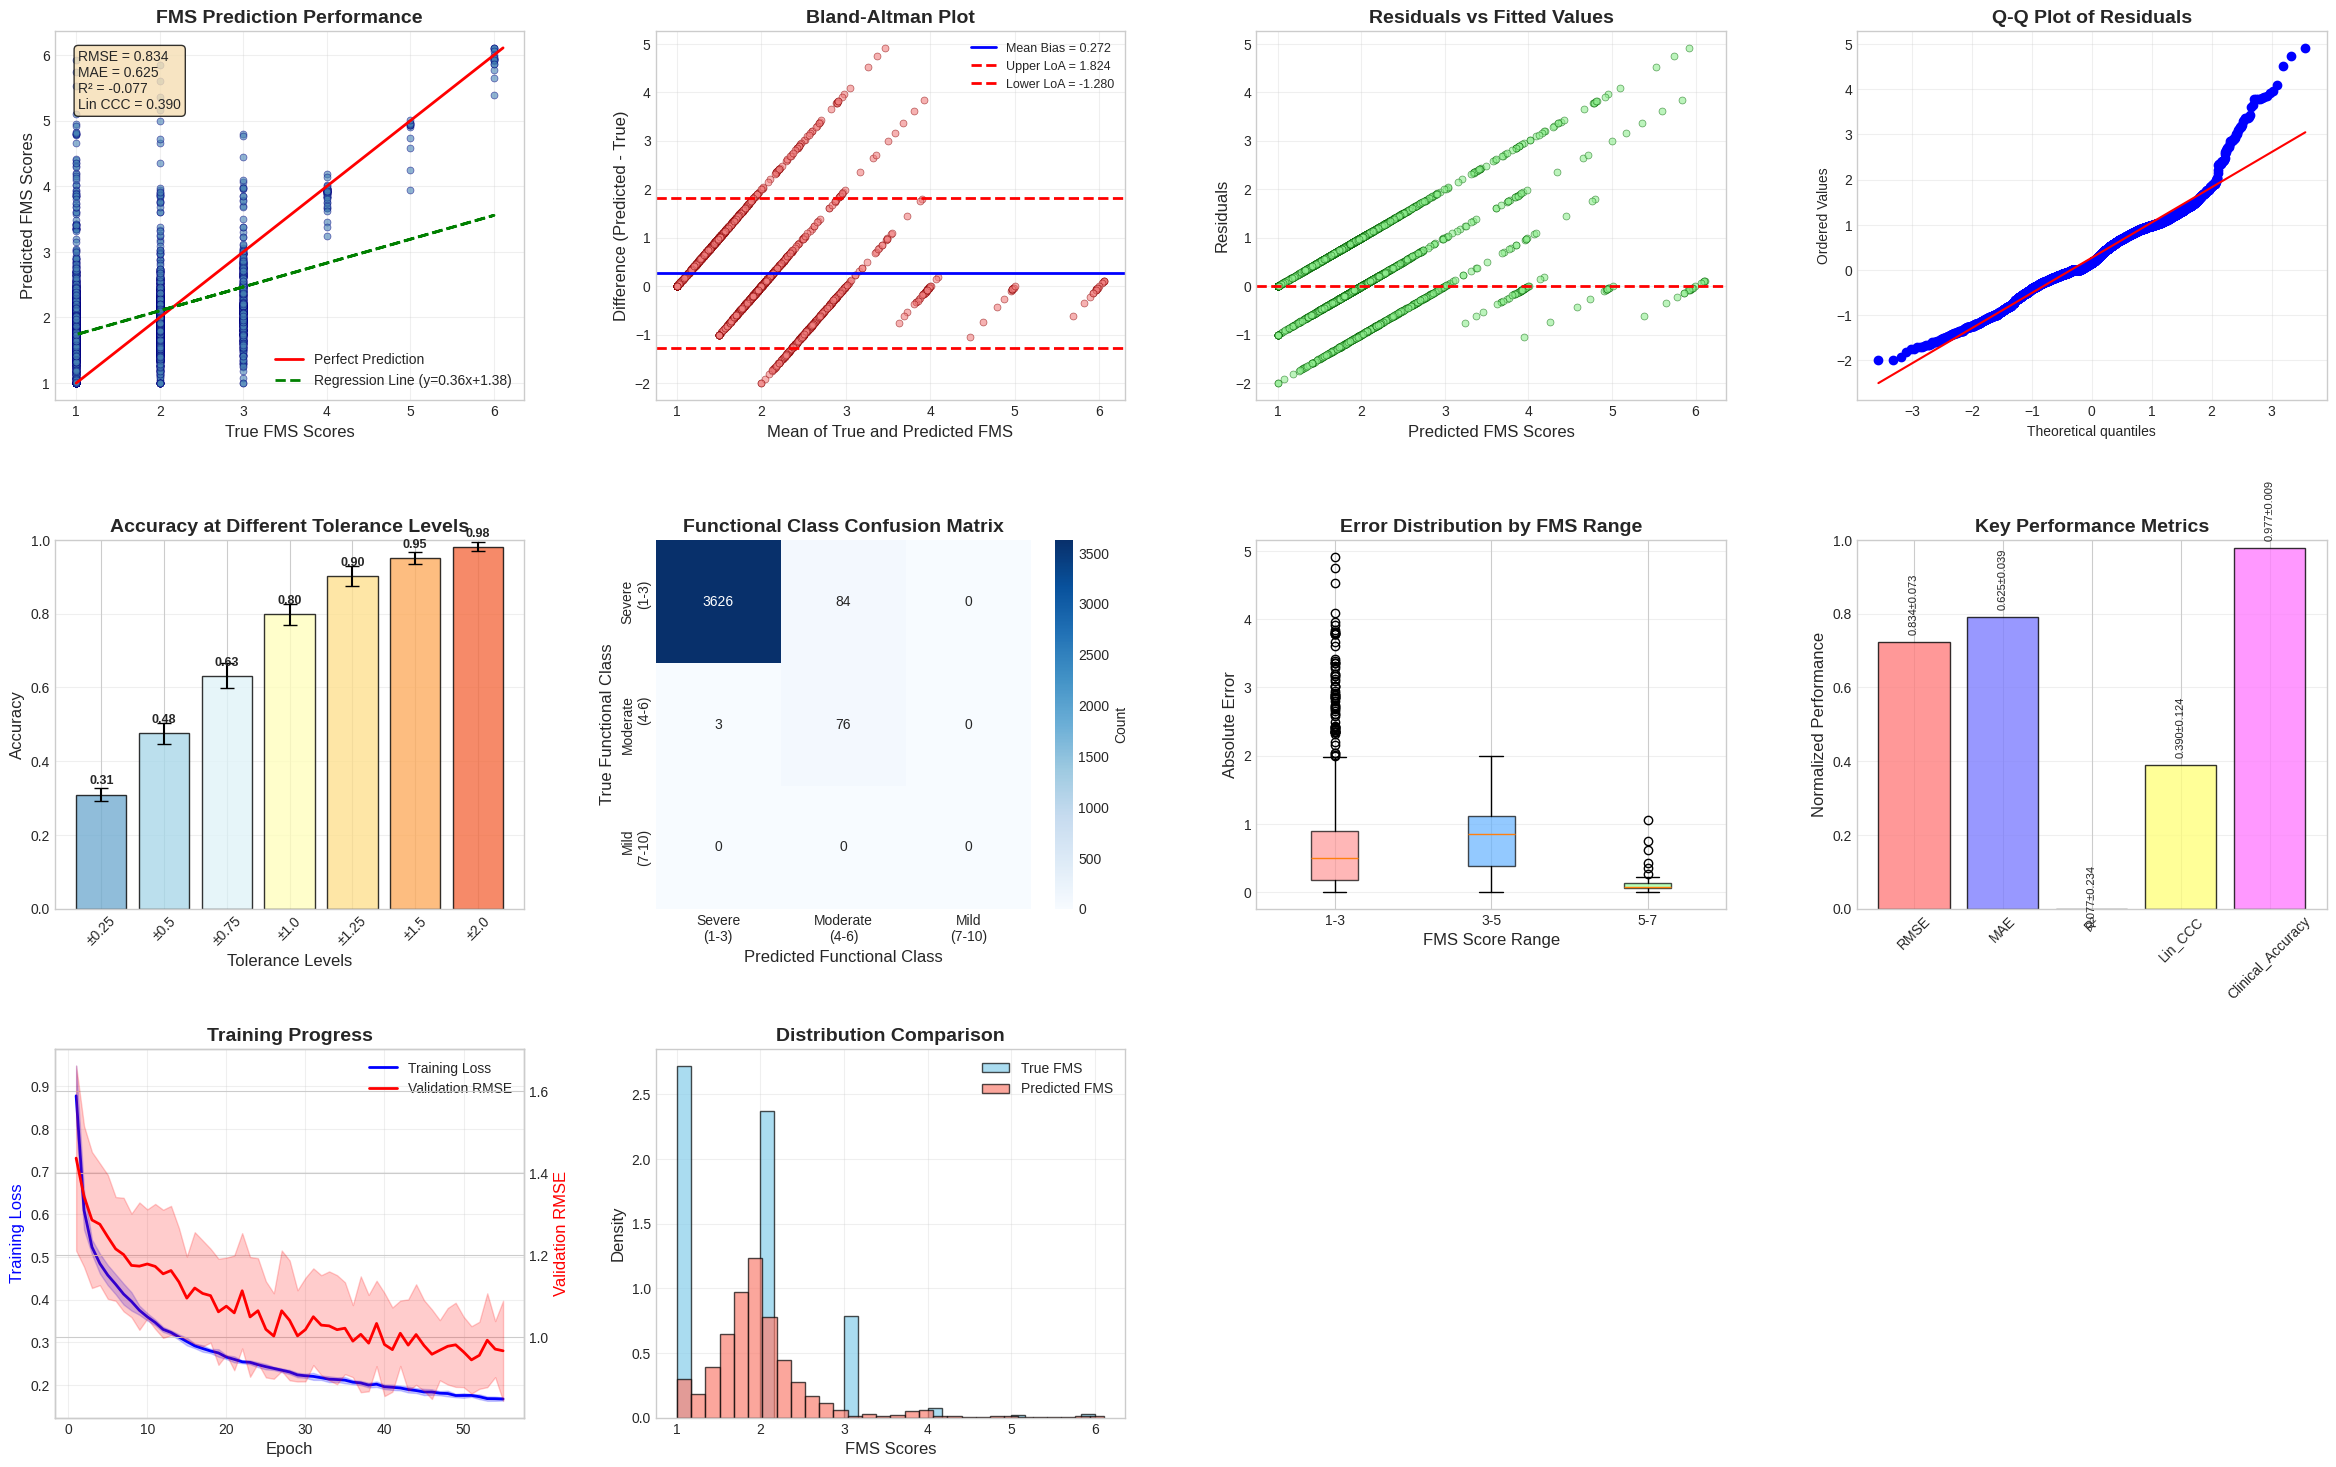


COMPREHENSIVE ACADEMIC PERFORMANCE ANALYSIS

PRIMARY REGRESSION METRICS:
  Root Mean Square Error (RMSE):     0.8341 ± 0.0731
  Mean Absolute Error (MAE):         0.6254 ± 0.0389
  Coefficient of Determination (R²): -0.0772 ± 0.2337
  Normalized MSE (NMSE):             1.0772 ± 0.2337
  Normalized MAE (NMAE):             0.9495 ± 0.0587

PERCENTAGE ERROR METRICS:
  Mean Absolute Percentage Error (MAPE):      48.89% ± 4.22%
  Symmetric Mean Absolute Percentage Error:   35.58% ± 1.74%

CLINICAL ACCURACY METRICS:
  Accuracy within ±0.25 FMS points:  0.3096 ± 0.0176 (31.0%)
  Accuracy within ±0.5  FMS points:  0.4753 ± 0.0280 (47.5%)
  Accuracy within ±1.0  FMS points:  0.7984 ± 0.0290 (79.8%)
  Accuracy within ±1.5  FMS points:  0.9514 ± 0.0163 (95.1%)
  Accuracy within ±2.0  FMS points:  0.9813 ± 0.0120 (98.1%)

FUNCTIONAL CLASS METRICS:
  Clinical Accuracy (exact class):    0.9770 ± 0.0087 (97.7%)
  Adjacent Class Accuracy (±1 class): 1.0000 ± 0.0000 (100.0%)

STATISTICAL MEASURES:
  P

In [ ]:
if __name__ == "__main__":
    # Display usage examples first
    usage_examples()
    print("\n" + "="*80)

    # Run main pipeline
    try:
        results = main()

        if results is not None:
            print(f"\n{'='*80}")
            print("PIPELINE COMPLETED SUCCESSFULLY!")
            print("All results, visualizations, and reports have been generated.")
            print(f"{'='*80}")
        else:
            print(f"\n{'='*80}")
            print("PIPELINE FAILED - Please review error messages above")
            print(f"{'='*80}")

    except KeyboardInterrupt:
        print("\n\nPipeline interrupted by user.")
        print("To resume, simply run the script again.")

    except Exception as e:
        print(f"\n\nUnexpected error: {str(e)}")
        print("Please review the error details and try again.")
        import traceback
        traceback.print_exc()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib
matplotlib.rcParams.update({'font.size': 12})

def save_individual_figures_pdf(fold_results, cv_metrics, output_dir="fms_figures"):
    """Save each figure as a separate PDF for publication"""

    import os
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Set publication-ready style
    plt.rcParams.update({
        'figure.figsize': (10, 8),
        'font.size': 12,
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'xtick.labelsize': 11,
        'ytick.labelsize': 11,
        'legend.fontsize': 11,
        'font.family': 'DejaVu Sans',
        'axes.linewidth': 1.2,
        'grid.alpha': 0.3,
        'lines.linewidth': 2.0
    })

    # Combine all results
    all_predictions = np.concatenate([fold['predictions'] for fold in fold_results])
    all_targets = np.concatenate([fold['targets'] for fold in fold_results])
    residuals = all_predictions - all_targets

    return all_predictions, all_targets, residuals, output_dir

In [ ]:
def save_regression_plot(all_targets, all_predictions, cv_metrics, output_dir):
    """Save main regression plot"""
    fig, ax = plt.subplots(figsize=(10, 8))

    # Scatter plot
    ax.scatter(all_targets, all_predictions, alpha=0.6, s=40, c='steelblue',
              edgecolors='navy', linewidth=0.5)

    # Perfect prediction line
    min_val = min(all_targets.min(), all_predictions.min())
    max_val = max(all_targets.max(), all_predictions.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r-', lw=2.5,
            label='Perfect Prediction', alpha=0.8)

    # Regression line
    z = np.polyfit(all_targets, all_predictions, 1)
    p = np.poly1d(z)
    ax.plot(all_targets, p(all_targets), 'g--', lw=2.5,
            label=f'Regression Line (y={z[0]:.2f}x+{z[1]:.2f})', alpha=0.8)

    ax.set_xlabel('True FMS Scores', fontsize=14, fontweight='bold')
    ax.set_ylabel('Predicted FMS Scores', fontsize=14, fontweight='bold')
    ax.set_title('FMS Prediction Performance', fontsize=16, fontweight='bold', pad=20)
    ax.legend(fontsize=12, loc='lower right')
    ax.grid(True, alpha=0.3)

    # Statistics box
    stats_text = (f'RMSE = {cv_metrics["RMSE_mean"]:.3f}\n'
                 f'MAE = {cv_metrics["MAE_mean"]:.3f}\n'
                 f'R² = {cv_metrics["R²_mean"]:.3f}\n'
                 f'Lin CCC = {cv_metrics["Lin_CCC_mean"]:.3f}')
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5',
            facecolor='white', edgecolor='black', alpha=0.9))

    plt.tight_layout()
    plt.savefig(f'{output_dir}/01_regression_plot.pdf', dpi=300, bbox_inches='tight')
    plt.close()

def save_bland_altman_plot(all_targets, all_predictions, cv_metrics, output_dir):
    """Save Bland-Altman plot"""
    fig, ax = plt.subplots(figsize=(10, 8))

    mean_values = (all_targets + all_predictions) / 2
    differences = all_predictions - all_targets

    ax.scatter(mean_values, differences, alpha=0.6, s=40, c='lightcoral',
              edgecolors='darkred', linewidth=0.5)

    # Mean difference line
    mean_diff = np.mean(differences)
    ax.axhline(y=mean_diff, color='blue', linestyle='-', lw=2.5,
               label=f'Mean Bias = {mean_diff:.3f}')

    # Limits of agreement
    std_diff = np.std(differences)
    upper_loa = mean_diff + 1.96 * std_diff
    lower_loa = mean_diff - 1.96 * std_diff

    ax.axhline(y=upper_loa, color='red', linestyle='--', lw=2.5,
               label=f'Upper LoA = {upper_loa:.3f}')
    ax.axhline(y=lower_loa, color='red', linestyle='--', lw=2.5,
               label=f'Lower LoA = {lower_loa:.3f}')

    ax.set_xlabel('Mean of True and Predicted FMS', fontsize=14, fontweight='bold')
    ax.set_ylabel('Difference (Predicted - True)', fontsize=14, fontweight='bold')
    ax.set_title('Bland-Altman Agreement Plot', fontsize=16, fontweight='bold', pad=20)
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{output_dir}/02_bland_altman_plot.pdf', dpi=300, bbox_inches='tight')
    plt.close()

def save_residuals_plot(all_predictions, residuals, output_dir):
    """Save residuals plot"""
    fig, ax = plt.subplots(figsize=(10, 8))

    ax.scatter(all_predictions, residuals, alpha=0.6, s=40, c='lightgreen',
              edgecolors='darkgreen', linewidth=0.5)
    ax.axhline(y=0, color='red', linestyle='--', lw=2.5, alpha=0.8)

    ax.set_xlabel('Predicted FMS Scores', fontsize=14, fontweight='bold')
    ax.set_ylabel('Residuals (Predicted - True)', fontsize=14, fontweight='bold')
    ax.set_title('Residuals vs Fitted Values', fontsize=16, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{output_dir}/03_residuals_plot.pdf', dpi=300, bbox_inches='tight')
    plt.close()

def save_qq_plot(residuals, output_dir):
    """Save Q-Q plot"""
    fig, ax = plt.subplots(figsize=(10, 8))

    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=ax)
    ax.set_title('Q-Q Plot of Residuals', fontsize=16, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3)

    # Enhance axis labels
    ax.set_xlabel('Theoretical Quantiles', fontsize=14, fontweight='bold')
    ax.set_ylabel('Sample Quantiles', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.savefig(f'{output_dir}/04_qq_plot.pdf', dpi=300, bbox_inches='tight')
    plt.close()

def save_accuracy_metrics_plot(cv_metrics, output_dir):
    """Save accuracy metrics bar chart"""
    fig, ax = plt.subplots(figsize=(12, 8))

    accuracy_metrics = ['Acc@0.25', 'Acc@0.5', 'Acc@0.75', 'Acc@1.0',
                       'Acc@1.25', 'Acc@1.5', 'Acc@2.0']
    accuracy_values = [cv_metrics[f'{metric}_mean'] for metric in accuracy_metrics]
    accuracy_stds = [cv_metrics[f'{metric}_std'] for metric in accuracy_metrics]

    colors = plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, len(accuracy_metrics)))
    x_pos = np.arange(len(accuracy_metrics))

    bars = ax.bar(x_pos, accuracy_values, yerr=accuracy_stds, capsize=7,
                 alpha=0.8, color=colors, edgecolor='black', linewidth=1.5)

    ax.set_xlabel('Tolerance Levels (FMS Points)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Accuracy', fontsize=14, fontweight='bold')
    ax.set_title('Accuracy at Different Tolerance Levels', fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x_pos)
    ax.set_xticklabels([m.replace('Acc@', '±') for m in accuracy_metrics])
    ax.set_ylim(0, 1.05)
    ax.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, accuracy_values)):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{val:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.savefig(f'{output_dir}/05_accuracy_metrics.pdf', dpi=300, bbox_inches='tight')
    plt.close()

def save_confusion_matrix_plot(all_targets, all_predictions, output_dir):
    """Save functional class confusion matrix"""
    fig, ax = plt.subplots(figsize=(10, 8))

    # Define functional classes
    class_bounds = [0, 3.5, 6.5, 10.1]
    class_labels = ['Severe (1-3)', 'Moderate (4-6)', 'Mild (7-10)']

    true_classes = np.digitize(all_targets, class_bounds) - 1
    pred_classes = np.digitize(all_predictions, class_bounds) - 1

    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(true_classes, pred_classes, labels=[0, 1, 2])

    # Create heatmap
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.figure.colorbar(im, ax=ax, shrink=0.8)

    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                   ha="center", va="center", fontsize=14, fontweight='bold',
                   color="white" if cm[i, j] > thresh else "black")

    ax.set_xlabel('Predicted Functional Class', fontsize=14, fontweight='bold')
    ax.set_ylabel('True Functional Class', fontsize=14, fontweight='bold')
    ax.set_title('Functional Class Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(np.arange(len(class_labels)))
    ax.set_yticks(np.arange(len(class_labels)))
    ax.set_xticklabels(class_labels)
    ax.set_yticklabels(class_labels)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    plt.tight_layout()
    plt.savefig(f'{output_dir}/06_confusion_matrix.pdf', dpi=300, bbox_inches='tight')
    plt.close()

def save_error_distribution_plot(all_targets, residuals, output_dir):
    """Save error distribution by FMS ranges"""
    fig, ax = plt.subplots(figsize=(10, 8))

    fms_ranges = [(1, 3), (3, 5), (5, 7), (7, 10)]
    range_errors = []
    range_labels = []
    range_colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

    for low, high in fms_ranges:
        mask = ((all_targets >= low) & (all_targets < high)) if high < 10 else ((all_targets >= low) & (all_targets <= high))
        if np.any(mask):
            range_residuals = np.abs(residuals[mask])
            range_errors.append(range_residuals)
            range_labels.append(f'{low}-{high}')

    if range_errors:
        box_plot = ax.boxplot(range_errors, labels=range_labels, patch_artist=True, widths=0.6)
        for patch, color in zip(box_plot['boxes'], range_colors[:len(range_errors)]):
            patch.set_facecolor(color)
            patch.set_alpha(0.8)
            patch.set_linewidth(1.5)

    ax.set_xlabel('FMS Score Range', fontsize=14, fontweight='bold')
    ax.set_ylabel('Absolute Error', fontsize=14, fontweight='bold')
    ax.set_title('Error Distribution by FMS Range', fontsize=16, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(f'{output_dir}/07_error_distribution.pdf', dpi=300, bbox_inches='tight')
    plt.close()

def save_training_progress_plot(fold_results, output_dir):
    """Save training progress plot"""
    fig, ax1 = plt.subplots(figsize=(12, 8))

    # Align training histories
    min_length = min(len(fold['train_losses']) for fold in fold_results if fold['train_losses'])
    if min_length > 0:
        train_losses_aligned = [fold['train_losses'][:min_length] for fold in fold_results if fold['train_losses']]
        val_rmses_aligned = [fold['val_rmses'][:min_length] for fold in fold_results if fold['val_rmses']]

        if train_losses_aligned and val_rmses_aligned:
            avg_train_loss = np.mean(train_losses_aligned, axis=0)
            avg_val_rmse = np.mean(val_rmses_aligned, axis=0)
            std_train_loss = np.std(train_losses_aligned, axis=0)
            std_val_rmse = np.std(val_rmses_aligned, axis=0)

            epochs = range(1, len(avg_train_loss) + 1)

            # Training loss
            color1 = 'tab:blue'
            ax1.set_xlabel('Epoch', fontsize=14, fontweight='bold')
            ax1.set_ylabel('Training Loss', color=color1, fontsize=14, fontweight='bold')
            line1 = ax1.plot(epochs, avg_train_loss, color=color1, linewidth=3, label='Training Loss')
            ax1.fill_between(epochs, avg_train_loss - std_train_loss, avg_train_loss + std_train_loss,
                           alpha=0.3, color=color1)
            ax1.tick_params(axis='y', labelcolor=color1)
            ax1.grid(True, alpha=0.3)

            # Validation RMSE
            ax2 = ax1.twinx()
            color2 = 'tab:red'
            ax2.set_ylabel('Validation RMSE', color=color2, fontsize=14, fontweight='bold')
            line2 = ax2.plot(epochs, avg_val_rmse, color=color2, linewidth=3, label='Validation RMSE')
            ax2.fill_between(epochs, avg_val_rmse - std_val_rmse, avg_val_rmse + std_val_rmse,
                           alpha=0.3, color=color2)
            ax2.tick_params(axis='y', labelcolor=color2)

            # Combined legend
            lines = line1 + line2
            labels = [l.get_label() for l in lines]
            ax1.legend(lines, labels, loc='upper right', fontsize=12)

            ax1.set_title('Training Progress (Mean ± SD)', fontsize=16, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.savefig(f'{output_dir}/08_training_progress.pdf', dpi=300, bbox_inches='tight')
    plt.close()

In [ ]:
def save_all_publication_figures(fold_results, cv_metrics, output_dir="fms_publication_figures"):
    """Save all figures as separate PDFs for publication"""

    print(f"\nSaving publication-ready figures to: {output_dir}/")

    # Prepare data and create output directory
    all_predictions, all_targets, residuals, output_dir = save_individual_figures_pdf(
        fold_results, cv_metrics, output_dir)

    # Save all individual figures
    save_regression_plot(all_targets, all_predictions, cv_metrics, output_dir)
    save_bland_altman_plot(all_targets, all_predictions, cv_metrics, output_dir)
    save_residuals_plot(all_predictions, residuals, output_dir)
    save_qq_plot(residuals, output_dir)
    save_accuracy_metrics_plot(cv_metrics, output_dir)
    save_confusion_matrix_plot(all_targets, all_predictions, output_dir)
    save_error_distribution_plot(all_targets, residuals, output_dir)
    save_training_progress_plot(fold_results, output_dir)

    # Reset matplotlib parameters
    plt.rcParams.update(plt.rcParamsDefault)

    print(f"✓ Saved 8 publication-ready figures as individual PDFs")
    print(f"✓ All figures saved with 300 DPI resolution")
    print(f"✓ Text sized appropriately for academic papers")

    return output_dir

In [ ]:
# Add this at the end of your run_enhanced_pipeline function or after getting results:
if results is not None:
    # Save individual publication figures
    figure_dir = save_all_publication_figures(results['fold_results'], results['cv_metrics'])
    print(f"\nPublication figures available in: {figure_dir}/")


Saving publication-ready figures to: fms_publication_figures/
✓ Saved 8 publication-ready figures as individual PDFs
✓ All figures saved with 300 DPI resolution
✓ Text sized appropriately for academic papers

Publication figures available in: fms_publication_figures/
